In [1]:
!pip install torchmetrics
!pip install thop
!pip install yacs
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 75.0 MB/s eta 0:00:00


In [2]:
#import

import zipfile
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
from thop import profile, clever_format

import torch.nn as nn
import torch.optim as optim

from torchmetrics import JaccardIndex
import torch.nn.functional as F
import random

from tqdm import tqdm

import time
import logging

from torch.utils.data import Dataset, DataLoader, Subset

import torchvision.transforms as T
from sklearn.metrics import mean_squared_error

In [3]:
!wget https://zenodo.org/record/5706578/files/Train.zip
!wget https://zenodo.org/record/5706578/files/Val.zip

--2025-01-21 08:10:50--  https://zenodo.org/record/5706578/files/Train.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/5706578/files/Train.zip [following]
--2025-01-21 08:10:51--  https://zenodo.org/records/5706578/files/Train.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 4021669263 (3.7G) [application/octet-stream]
Saving to: ‘Train.zip’

Train.zip           100%[===================>]   3.75G  12.4MB/s    in 5m 1s   

2025-01-21 08:15:52 (12.8 MB/s) - ‘Train.zip’ saved [4021669263/4021669263]

--2025-01-21 08:15:52--  https://zenodo.org/record/5706578/files/Val.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request 

In [4]:
!wget https://zenodo.org/records/14606189/files/PIDNet_S_ImageNet.pth.tar

--2025-01-21 08:18:53--  https://zenodo.org/records/14606189/files/PIDNet_S_ImageNet.pth.tar
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38061375 (36M) [application/octet-stream]
Saving to: ‘PIDNet_S_ImageNet.pth.tar’

PIDNet_S_ImageNet.p 100%[===================>]  36.30M  11.8MB/s    in 3.8s    

2025-01-21 08:18:58 (9.58 MB/s) - ‘PIDNet_S_ImageNet.pth.tar’ saved [38061375/38061375]



In [5]:
# Define file paths
train_zip = "Train.zip"
val_zip = "Val.zip"

# Extract Train.zip
with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall("Train")

# Extract Val.zip
with zipfile.ZipFile(val_zip, 'r') as zip_ref:
    zip_ref.extractall("Val")


# Verify the extracted folders
print("Train Directory Contents:", os.listdir("Train"))
print("Val Directory Contents:", os.listdir("Val"))

Train Directory Contents: ['Train']
Val Directory Contents: ['Val']


In [6]:
#TASK 5

COLOR_MAP = {
    'Background': 0.00392157,
    'Building': 0.00784314,
    'Road': 0.01176471,
    'Water': 0.01568628,
    'Barren': 0.01960784,
    'Forest': 0.02352941,
    'Agricultural': 0.02745098
}

LABEL_MAP = OrderedDict(
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6
)

# Tolerance-based color to label conversion
def color_to_one_hot(mask, label_map, tolerance=0.001, num_classes=7):
    mask = np.asarray(mask, dtype=np.float32)
    if len(mask.shape) == 2:  # Ensure channel dimension exists
        mask = np.expand_dims(mask, axis=0)  # Convert [H, W] to [1, H, W]

    one_hot_mask = np.zeros((num_classes, mask.shape[1], mask.shape[2]), dtype=np.float32)

    for class_name, class_index in label_map.items():
        color_value = COLOR_MAP[class_name]
        # Match pixels with the grayscale value within the tolerance
        matches = np.abs(mask - color_value) < tolerance
        one_hot_mask[class_index, np.squeeze(matches, axis=0)] = 1.0

    return torch.from_numpy(one_hot_mask)


# Define a function to denormalize the image
def denormalize(tensor, mean, std):
    """ Denormalize the tensor back to the [0, 1] range for visualization. """
    for i in range(len(mean)):
        tensor[i] = tensor[i] * std[i] + mean[i]
    return tensor

def show_image(image_tensor):
    """ Display a transformed image using matplotlib. """
    image_tensor = image_tensor.cpu()  # Sposta il tensore sulla CPU
    image_tensor = denormalize(image_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Denormalize the image
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert to HxWxC format
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

def show_mask(mask_tensor, num_classes=7):
    """ Display the mask using matplotlib. """
    # Convert the one-hot mask to the label mask (indices of the highest value per pixel)
    mask = mask_tensor.squeeze().cpu().numpy()  # Remove the batch dimension and convert to numpy
    label_mask = np.argmax(mask, axis=0)  # Get the class index with the highest value for each pixel

    plt.imshow(label_mask, cmap='tab20')  # Use a colormap suitable for categorical data
    plt.colorbar()  # Optionally add a color bar
    plt.axis('off')  # Hide axes
    plt.show()


def colorJitter(colorJitter, img_mean, data = None, target = None, s=0.25):
    # s is the strength of colorjitter
    #colorJitter
    if not (data is None):
        if data.shape[1]==3:
            if colorJitter > 0.2:
                img_mean, _ = torch.broadcast_tensors(img_mean.unsqueeze(0).unsqueeze(2).unsqueeze(3), data)
                seq = nn.Sequential(kornia.augmentation.ColorJitter(brightness=s,contrast=s,saturation=s,hue=s))
                data = (data+img_mean)/255
                data = seq(data)
                data = (data*255-img_mean).float()
    return data, target

def gaussian_blur(blur, data = None, target = None):
    if not (data is None):
        if data.shape[1]==3:
            if blur > 0.5:
                sigma = np.random.uniform(0.15,1.15)
                kernel_size_y = int(np.floor(np.ceil(0.1 * data.shape[2]) - 0.5 + np.ceil(0.1 * data.shape[2]) % 2))
                kernel_size_x = int(np.floor(np.ceil(0.1 * data.shape[3]) - 0.5 + np.ceil(0.1 * data.shape[3]) % 2))
                kernel_size = (kernel_size_y, kernel_size_x)
                seq = nn.Sequential(kornia.filters.GaussianBlur2d(kernel_size=kernel_size, sigma=(sigma, sigma)))
                data = seq(data)
    return data, target

def strongTransform(parameters, data=None, target=None):
    assert ((data is not None) or (target is not None))
    # data, target = transformsgpu.oneMix(mask = parameters["Mix"], data = data, target = target)
    data, target = colorJitter(colorJitter = parameters["ColorJitter"], img_mean = torch.from_numpy(IMG_MEAN.copy()).cuda(), data = data, target = target)
    data, target = gaussian_blur(blur = parameters["GaussianBlur"], data = data, target = target)
    # data, target = transformsgpu.flip(flip = parameters["flip"], data = data, target = target)
    return data, target



class LoveDADataset(Dataset):
    def __init__(self, root_dir, split='train', transform_image=None, transform_label=None, subdir="Rural", aug1=False, aug2=False):
        self.root_dir = root_dir
        self.split = split
        self.transform_image = transform_image
        self.transform_label = transform_label
        self.aug1 = aug1
        self.aug2 = aug2
        self.image_paths = []
        self.label_paths = []

        image_dir = os.path.join(root_dir, split, subdir, 'images_png')
        label_dir = os.path.join(root_dir, split, subdir, 'masks_png')

        for f in os.listdir(image_dir):
            if f.endswith('.png'):
                self.image_paths.append(os.path.join(image_dir, f))
                self.label_paths.append(os.path.join(label_dir, f))

    def __len__(self):
        original_length = len(self.image_paths)
        if self.aug1 and self.aug2:
            return original_length * 2
        elif self.aug1 or self.aug2:
            return int(original_length * 1.5)
        else:
            return original_length


    def __getitem__(self, idx):
        original_length = len(self.image_paths)

        # Calcola l'indice originale nel dataset
        idx = idx % original_length

        aug_1 = False
        aug_2 = False
        if(idx < original_length):
            aug_1 = False
            aug_2 = False

        elif(idx >= original_length):
            if(random.random() < 0.5):
                if(self.aug1):
                    aug_1 = True
                    aug_2 = False
                elif(self.aug2):
                    aug_1 = False
                    aug_2 = True

            else:
                if (self.aug2):
                    aug_1 = False
                    aug_2 = True
                elif(self.aug1):
                    aug_1 = True
                    aug_2 = False



        # Carica l'immagine e la maschera
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = Image.open(self.label_paths[idx]).convert("L")

        image_np = np.array(image)
        label_np = np.array(label)

        # Seed per garantire coerenza tra immagine e maschera
        seed = np.random.randint(2147483647)

        # Applica augmentazione se abilitata
        if self.aug1 and aug_1:
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            transform_aug1 = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(30)
            ])
            image = Image.fromarray(image_np)
            image = transform_aug1(image)
            image_np = np.array(image)

            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            label = Image.fromarray(label_np)
            label = transform_aug1(label)
            label_np = np.array(label)

        if self.aug2 and aug_2:
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)

            strong_parameters = {}
            strong_parameters["ColorJitter"] = random.uniform(0, 1)
            strong_parameters["GaussianBlur"] = random.uniform(0, 1)


            image = Image.fromarray(image_np)
            image, _ = strongTransform(strong_parameters, image, None)
            image_np = np.array(image)

            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            label = Image.fromarray(label_np)
            label_np = np.array(label)

        # Trasformazioni opzionali per immagine e maschera
        if self.transform_image:
            transform_image_alb = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            image = Image.fromarray(image_np)
            image = transform_image_alb(image)

        if self.transform_label:
            transform_label_alb = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor()
            ])
            label = Image.fromarray(label_np)
            label = transform_label_alb(label).squeeze(0)
            label = color_to_one_hot(label, LABEL_MAP)

        return image,label

# Define transformations without augmentations
transform_image = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

transform_label = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Set augmentation flags
AUG1 = True
AUG2 = True

BATCH_SIZE = 16 #or 32, or 64 ...
NUM_WORKERS = 2 # Number of cpu cores
PIN_MEMORY = True
PERSISTENT_WORKERS = False # Set true if you have persistent workers issues


In [7]:
!git clone https://github.com/XuJiacong/PIDNet.git
%cd content

Cloning into 'PIDNet'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 386 (delta 131), reused 125 (delta 125), pack-reused 193 (from 1)
Receiving objects: 100% (386/386), 212.80 MiB | 34.05 MiB/s, done.
Resolving deltas: 100% (184/184), done.
[Errno 2] No such file or directory: 'content'
/content


In [8]:
import sys
sys.path.append('/content/PIDNet')

In [9]:
from models.model_utils import BasicBlock, Bottleneck, segmenthead, DAPPM, PAPPM, PagFM, Bag, Light_Bag

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_


def get_seg_model(name, num_classes, imgnet_pretrained, model_pth):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=True)



    if imgnet_pretrained:

        pretrained_state = torch.load(model_pth, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        model.load_state_dict(model_dict, strict = False)

    else:

        pretrained_dict = torch.load(model_pth, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_seg_model(name='pidnet_s', num_classes=7, imgnet_pretrained=True, model_pth='PIDNet_S_ImageNet.pth.tar').to(device)




<ipython-input-9-43ad49fc9a51>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(model_pth, map_location='cpu')['state_dict']


In [10]:
from utils.criterion import OhemCrossEntropy
import gc


num_classes=7
# Define mIoU metric
jaccard = JaccardIndex(task="multiclass", num_classes=7).to('cuda')  # intersection over union. Directly measures the overlap between predicted segmentation and ground truth.

# DACS implementation (adapting from the pseudocode)
class DACSModel(nn.Module):
    def __init__(self, num_classes):
        super(DACSModel, self).__init__()
        self.model = get_seg_model(name='pidnet_s', num_classes=7, imgnet_pretrained=True, model_pth='PIDNet_S_ImageNet.pth.tar').to(device)

    def forward(self, x):
        return self.model(x)


def dice_loss(predictions, labels, smooth=1e-6):
    """
    Computes the Dice Loss between the predicted and ground truth labels.
    """
    # Convert predictions and labels to probabilities and one-hot encoding
    pred_probs = F.softmax(predictions, dim=1)  # Shape: (batch_size, num_classes, height, width)
    label_one_hot = F.one_hot(labels, num_classes=predictions.size(1)).permute(0, 3, 1, 2).float()

    # Compute intersection and union
    intersection = torch.sum(pred_probs * label_one_hot, dim=(0, 2, 3))
    union = torch.sum(pred_probs, dim=(0, 2, 3)) + torch.sum(label_one_hot, dim=(0, 2, 3))

    # Dice coefficient
    dice = (2. * intersection + smooth) / (union + smooth)

    # Dice loss
    return 1 - dice.mean()



def boundary_loss(predictions, labels, device="cuda"):
    """
    Computes the boundary loss between the predicted and ground truth boundaries.
    """
    # Convert predictions to probabilities
    pred_probs = F.softmax(predictions, dim=1)  # Shape: (batch_size, num_classes, height, width)

    # Convert labels to one-hot encoding and float
    label_one_hot = F.one_hot(labels, num_classes=predictions.size(1)).permute(0, 3, 1, 2).float()

    # Compute boundary maps using a convolutional kernel
    kernel = torch.ones(1, 1, 3, 3).to(device)
    pred_boundary = F.conv2d(pred_probs[:, 1:2], weight=kernel, stride=1, padding=1)
    label_boundary = F.conv2d(label_one_hot[:, 1:2], weight=kernel, stride=1, padding=1)

    # Compute MSE loss between boundary maps
    return F.mse_loss(pred_boundary, label_boundary)





def compute_loss(pred_source, label_source, pred_mixed, label_mixed, lambda_param, loss_type="cross_entropy",  perturbation=None):
    # criterion = OhemCrossEntropy()

    criterion = nn.CrossEntropyLoss()
    # Cross-entropy loss for source domain and mixed domain
    if loss_type == "cross_entropy":
        loss_source = criterion(pred_source, label_source)
        loss_mixed = criterion(pred_mixed, label_mixed)
    # Boundary loss
    elif loss_type == "boundary":
        loss_source = boundary_loss(pred_source, label_source)
        loss_mixed = boundary_loss(pred_mixed, label_mixed)
    # Dice loss
    elif loss_type == "dice":
        # print("diceeee")
        loss_source = dice_loss(pred_source, label_source)
        loss_mixed = dice_loss(pred_mixed, label_mixed)
    else:
        raise ValueError("Unknown loss type")

    return loss_source + lambda_param * loss_mixed


def adjust_mask(binary_mask, source_labels, target_proportion=0.2):
    """
    Regola la maschera in modo da ridurre la quantità di pixel source
    quando la proporzione è troppo alta, e bilancia la proporzione tra source e target.

    Args:
    - binary_mask (Tensor): la maschera binaria che indica quali pixel provengono dalla source image.
    - source_labels (Tensor): le etichette della source image.
    - target_proportion (float): la proporzione di target che vogliamo ottenere dopo l'aggiornamento.

    Returns:
    - binary_mask (Tensor): la maschera aggiornata.
    """
    # Calcoliamo la proporzione attuale della source image
    proportion_source = binary_mask.float().mean().item()

    print(f"Proporzione source prima dell'aggiustamento: {proportion_source:.2f}")

    if proportion_source == 1.0:
        # Se tutti i pixel sono source, vogliamo ridurre la quantità di pixel source
        # Se la proporzione source è 1, significa che tutti i pixel sono della source image.
        # Abbiamo bisogno di "trasformare" alcuni di questi pixel in target per bilanciare la proporzione.

        # Determina quanti pixel devono essere cambiati per raggiungere la proporzione target desiderata
        target_pixels_needed = int(binary_mask.numel() * target_proportion)

        # Troviamo gli indici dei pixel source (True) nella maschera
        source_pixel_indices = binary_mask.nonzero(as_tuple=True)[0]

        # Calcoliamo quanti pixel dobbiamo convertire in target (False)
        num_to_convert = source_pixel_indices.size(0) - target_pixels_needed

        if num_to_convert > 0:
            # Scegliamo casualmente i pixel da modificare da source a target
            indices_to_convert = source_pixel_indices[:num_to_convert]

            # Impostiamo questi pixel su False (target)
            binary_mask[indices_to_convert] = False
        else:
            print("Non è necessario modificare la maschera, la proporzione è già adatta.")

    # Dopo l'aggiornamento, la proporzione di source dovrebbe essere bilanciata
    proportion_source = binary_mask.float().mean().item()
    print(f"Proporzione source dopo l'aggiustamento: {proportion_source:.2f}")

    return binary_mask

def classmix(source_images, source_labels, target_images, target_labels, num_classes=7):
    """
    Perform classmix image augmentation, mixing source domain image and target domain image pixels based on class masks.
    """
    batch_size, _, height, width = source_images.size()
    #print("sourceLabels",source_labels)

    # Ensure source_labels is an integer type
    source_labels = source_labels.long()

    # Generate a random binary mask for each class
    class_masks = torch.zeros((batch_size, height, width), device=source_images.device, dtype=torch.bool)
    #print(class_masks)
    #print(class_masks.shape) #torch.Size([2, 512, 512])
    #print(source_labels.shape) #torch.Size([2, 7, 512, 512])
    #source_labels = torch.argmax(source_labels, dim=1)  # Convert to class indices (batch_size, height, width)

    for b in range(batch_size):
        best_proportion_source = 0.0  # To store the best proportion found
        best_class_mask = torch.zeros((height, width), device=source_images.device, dtype=torch.bool)  # Best mask found
        count = 0  # Initialize the count for while loop iterations
        proportion_source=0.0


        # Keep regenerating the mask until the proportion is within the desired range or count reaches 10
        while (proportion_source < 0.1 or proportion_source > 0.9) and count < 10:
            # Randomly select half of the classes for each image in the batch
            selected_classes = torch.randperm(num_classes)[:num_classes // 2]
            #print("selected_classes: ", selected_classes)

            # Reset the mask for this batch
            class_masks[b] = torch.zeros((height, width), device=source_images.device, dtype=torch.bool)

            for cls in selected_classes:
                class_masks[b] = class_masks[b] | (source_labels[b] == cls)

            # Calculate the proportion of source pixels in the mask
            proportion_source = class_masks[b].float().mean()
            #print("proportion_source:", proportion_source)

            # If this proportion is the best so far, store the mask and proportion
            if proportion_source > best_proportion_source:
                best_proportion_source = proportion_source
                best_class_mask = class_masks[b].clone()  # Store the best mask

            # Increment the count
            count += 1

            # If the count reaches 10, exit the loop
            if count >= 10:
                #print(f"Maximum iterations reached for batch {b}. Proportion did not satisfy the condition.")
                break

        # After the loop, use the best mask found
        #print(f"Best proportion_source for batch {b}: {best_proportion_source}")
        class_mask_rgb = best_class_mask.unsqueeze(0).repeat(3, 1, 1).float() * 255  # Convert to RGB
        #show_image(class_mask_rgb) #print the mask

        # Update the class mask for this batch
        class_masks[b] = best_class_mask

    # Expand the mask to match the channel dimension for images
    class_masks_expanded = class_masks.unsqueeze(1).expand(-1, source_images.size(1), -1, -1)

    # Mix images using the masks
    mixed_images = torch.where(class_masks_expanded, source_images, target_images)



    # Mix labels using the same masks
    mixed_labels = torch.where(class_masks, source_labels, target_labels)


    return mixed_images, mixed_labels

def calculate_miou(predictions, labels, num_classes=7):
    """
    Compute Mean Intersection over Union (mIoU) for a given batch of mixed images.
    Args:
    - predictions (torch.Tensor): Predicted labels for each pixel in the batch (B, H, W)
    - labels (torch.Tensor): Ground truth labels for each pixel in the batch (B, H, W)
    - num_classes (int): The total number of classes for segmentation
    Returns:
    - mean_iou (float): The mean Intersection over Union (mIoU) for the batch
    """
    iou_per_class = []

    # Loop over each class
    for cls in range(num_classes):
        # Predicted pixels belonging to the class
        pred_class = (predictions == cls)
        # Ground truth pixels belonging to the class
        true_class = (labels == cls)

        # Intersection (True Positive)
        intersection = torch.sum(pred_class & true_class).float()
        # Union (True Positive + False Positive + False Negative)
        union = torch.sum(pred_class | true_class).float()

        # IoU for the class
        if union != 0:
            iou = intersection / union
        else:
            iou = torch.tensor(0.0)

        iou_per_class.append(iou)

    # Calculate the mean IoU for the batch
    mean_iou = torch.mean(torch.stack(iou_per_class))
    return mean_iou

def calculate_lambda(predictions, threshold=0.7):
    """
    Calculate the adaptive lambda based on the proportion of confident pixels.

    Args:
    - predictions (torch.Tensor): Model predictions (logits or probabilities) [batch_size, num_classes, H, W].
    - threshold (float): Confidence threshold for determining confident pixels.

    Returns:
    - lambda_value (float): Adaptive lambda for the current batch.
    """
    # Convert logits to probabilities (if necessary)
    #print("predictions: ", predictions.shape) #torch.Size([2, 7, 512, 512])
    probs = F.softmax(predictions, dim=1)  # [batch_size, num_classes, H, W] #we apply the softmax
    #print("probs: ", probs.shape) #torch.Size([2, 7, 512, 512])

    # Get maximum probabilities for each pixel
    max_probs, _ = probs.max(dim=1)  # [batch_size, H, W]

    # Create a mask of confident pixels
    confident_mask = max_probs > threshold  # [batch_size, H, W]

    # Calculate the proportion of confident pixels for each image in the batch
    confident_proportions = confident_mask.float().mean(dim=(1, 2))  # [batch_size]

    # Average over the batch to get the lambda value
    lambda_value = confident_proportions.mean().item()

    return lambda_value

# DACS training loop
def train_dacs_and_validate(model, source_loader, target_loader,loss_type, num_epochs=20, lambda_param=0.7, lr=1e-4, confidence_threshold=0.7  ):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)  # Move model to device (CUDA or CPU)
    model.train()
    best_miou = 0.0

    for epoch in range(num_epochs):

        # Iterate through both source and target datasets for training
        train_progress_bar = tqdm(zip(source_loader, target_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch", total=min(len(source_loader), len(target_loader)))
        for batch_idx, (source_data, target_data) in enumerate(train_progress_bar):

            source_images, source_labels = source_data
            #print("source_images: ", source_images.shape)
            if source_images.shape[0]==1: # when we run subset
              continue
            target_images, _ = target_data  # Target labels are not available, will use pseudo-labels

            # Move to device
            source_images, source_labels = source_images.to(device), source_labels.to(device)
            target_images = target_images.to(device)

            # 1. Forward pass through the model for the source and target domains
            source_preds = model(source_images)
            main_output_source= source_preds[1]

            #print("main_output_source shape : ", main_output_source.shape)
            main_output_source = F.interpolate(main_output_source, size=(512,512), mode='bilinear', align_corners=True)
            #print("main_output_source shape : ", main_output_source.shape) #torch.Size([2, 7, 512, 512])
            #print("logits", main_output_source[0, :, 0, 0]) #example: tensor([-3.4636, -3.5338,  2.0996, -0.4825, -0.7998,  1.7863,  2.0860], device='cuda:0', grad_fn=<SelectBackward0>)


            # 2. Generate pseudo-label for target domain
            target_preds = model(target_images)
            main_output_target = target_preds[1]
            #print("main_output_target shape : ", main_output_target.shape)
            main_output_target = F.interpolate(main_output_target, size=(512,512), mode='bilinear', align_corners=True)
            #print("main_output_target shape : ", main_output_target.shape) #torch.Size([2, 7, 512, 512])

            #The goal of pseudo-labeling is to assign a single class label to each pixel based on the highest probability (or logit). The argmax function finds the index of the maximum value along the specified dimension (num_classes). The result tensor is (batch_size, height, width)
            pseudo_labels = torch.argmax(main_output_target, dim=1).to(device)
            #print("pseudo_labels", pseudo_labels.shape) #torch.Size([2, 512, 512])
            #print("source labels :", source_labels) #here each class label is represented as a one-hot vector for each pixel across the image. we want convert the one-hot encoded source_labels into class indices, so each pixel gets assigned the class marked as 1 in the one-hot vector.

            #If a pixel in source_labels has a one-hot encoded value like [1, 0, 0, 0], this means that the pixel belongs to class 0 (the first class). ->
            source_labels = torch.argmax(source_labels, dim=1).to(device)
            #print("source_labels", source_labels.shape) # torch.Size([2, 512, 512])

            #3. Calculate adaptive lambda
            #lambda_param = calculate_lambda(main_output_target, threshold=confidence_threshold)
            #train_progress_bar.set_postfix({'lambda': lambda_param})

            # 4. MIX source and target images and labels (DACS augmentation step)
            mixed_images, mixed_labels = classmix(source_images, source_labels, target_images, pseudo_labels)
            #print("mixed_labels ", mixed_labels.shape)
            mixed_labels=mixed_labels.to(device)
            #print("mixed_labels", mixed_labels.shape)

            # Visualization: Save and show one example from the batch
            # if (batch_idx == 61):  # Show only for the last batch of each epoch. We can try only for 1 batch in 1 epoch at max, otherwise output is truncated.
#                 print(f"Visualizing images from batch {batch_idx} at epoch {epoch+1}:")
#                 for i in range(16):
#                     print(f"Source Image {i + 1}:")
#                     show_image(source_images[i])
#                     print(f"Target Image {i + 1}:")
#                     show_image(target_images[i])
#                     print(f"Mixed Image {i + 1}:")
#                     show_image(mixed_images[i])


            # Step 6: Forward pass
            mixed_preds = model(mixed_images)
            main_output_mixed = mixed_preds[1]
            main_output_mixed = F.interpolate(main_output_mixed, size=(512, 512), mode='bilinear', align_corners=True)

            # Calculate the loss
            # loss = dacs_loss(main_output_source, source_labels, main_output_mixed, mixed_labels, lambda_param)
            # Esempio di utilizzo

            # pred_source, label_source, pred_mixed, label_mixed, lambda_param
            loss = compute_loss(main_output_source, source_labels, main_output_mixed, mixed_labels, lambda_param=0.5,
                            loss_type=loss_type)


            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Print loss and mIoU after each epoch
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.4f}")

        # Clear GPU memory
        torch.cuda.empty_cache()

        # Validation loop
        model.eval()
        val_miou = 0.0
        val_class_iou = torch.zeros(len(LABEL_MAP)).to('cuda')  # Store IoU per class
        val_class_counts = torch.zeros(len(LABEL_MAP)).to('cuda')  # To track number of pixels for each class

        val_progress_bar = tqdm(target_loader, desc=f"Validating Epoch {epoch + 1}/{num_epochs}", unit="batch", total=len(target_loader))

        with torch.no_grad():
            for images, masks in val_progress_bar:
                images, masks = images.to('cuda'), masks.to('cuda')

                # Forward pass
                outputs = model(images)  # [batch_size, num_classes, 512, 512] #outputs obtained with model trained on mixed images.
                main_output = outputs[1]
                main_output = F.interpolate(main_output, size=(512,512), mode='bilinear', align_corners=True)
                preds = torch.argmax(main_output, dim=1)  # [batch_size, 512, 512] #select the class with max probability for each pixel

                # Convert masks to class indices format if one-hot encoded
                if masks.ndim == 4:  # [batch_size, num_classes, height, width]
                    masks = masks.argmax(dim=1)  # [batch_size, height, width]

                # Calculate per-class IoU
                for c, class_name in LABEL_MAP.items():  # Iterate over LABEL_MAP classes
                    true_class = (masks == class_name)
                    pred_class = (preds == class_name)

                    intersection = torch.sum(true_class & pred_class).float()
                    union = torch.sum(true_class | pred_class).float()

                    if union != 0:
                        val_class_iou[class_name] += intersection / union
                    val_class_counts[class_name] += 1

                # Calculate overall mIoU for this batch
                val_miou += jaccard(preds, masks)

        # Average metrics
        val_miou /= len(target_loader)

        # Calculate average IoU for each class
        avg_class_iou = val_class_iou / val_class_counts

        # Print validation metrics at the end of each epoch
        print(f"Epoch [{epoch+1}/{num_epochs}] - Validation mIoU: {val_miou:.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}] - Per-Class IoU: {dict(zip(LABEL_MAP.keys(), avg_class_iou.tolist()))}")

        # Save the best model
        if val_miou > best_miou:
            best_miou = val_miou
            torch.save(model.state_dict(), 'best_pidnet_model.pth')

    print(f"Best Validation mIoU: {best_miou:.4f}")




# Loading datasets
source_dataset = LoveDADataset(root_dir='Train/', split='Train', transform_image=transform_image, transform_label=transform_label, subdir='Urban', aug1=AUG1, aug2=AUG2)
target_dataset = LoveDADataset(root_dir='Val/', split='Val', transform_image=transform_image, transform_label=transform_label, subdir='Rural')

source_loader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)
target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)


# Initialize, train the model and validate
model = DACSModel(num_classes=7).to(device)  # Assuming 7 classes


# loss_types = ["cross_entropy"]
# loss_types = ["boundary"]
loss_types = ["dice"]

for l in loss_types:
    print("------------------------------------- LOSS TYPE:   ", l, "   -----------------------------------")

    train_dacs_and_validate(model, source_loader, target_loader, l, num_epochs=20)

    print("_______________________________________________________________________________________________________________________")




------------------------------------- LOSS TYPE:    dice    -----------------------------------


<ipython-input-9-43ad49fc9a51>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(model_pth, map_location='cpu')['state_dict']
Epoch 1/20:   0%

diceeee


Epoch 1/20:   2%|▏         | 1/62 [00:13<13:54, 13.68s/batch]

diceeee


Epoch 1/20:   5%|▍         | 3/62 [00:14<03:27,  3.52s/batch]

diceeee


Epoch 1/20:   6%|▋         | 4/62 [00:15<02:17,  2.38s/batch]

diceeee


Epoch 1/20:   8%|▊         | 5/62 [00:17<02:10,  2.30s/batch]

diceeee


Epoch 1/20:  10%|▉         | 6/62 [00:19<01:57,  2.10s/batch]

diceeee


Epoch 1/20:  11%|█▏        | 7/62 [00:22<02:09,  2.35s/batch]

diceeee
diceeee


Epoch 1/20:  15%|█▍        | 9/62 [00:28<02:35,  2.93s/batch]

diceeee


Epoch 1/20:  16%|█▌        | 10/62 [00:30<02:12,  2.56s/batch]

diceeee


Epoch 1/20:  18%|█▊        | 11/62 [00:33<02:12,  2.59s/batch]

diceeee


Epoch 1/20:  19%|█▉        | 12/62 [00:35<01:56,  2.33s/batch]

diceeee
diceeee


Epoch 1/20:  21%|██        | 13/62 [00:38<02:05,  2.56s/batch]

diceeee


Epoch 1/20:  24%|██▍       | 15/62 [00:45<02:30,  3.20s/batch]

diceeee


Epoch 1/20:  26%|██▌       | 16/62 [00:46<01:57,  2.56s/batch]

diceeee


Epoch 1/20:  27%|██▋       | 17/62 [00:50<02:03,  2.74s/batch]

diceeee


Epoch 1/20:  29%|██▉       | 18/62 [00:51<01:40,  2.28s/batch]

diceeee


Epoch 1/20:  31%|███       | 19/62 [00:54<01:50,  2.58s/batch]

diceeee


Epoch 1/20:  32%|███▏      | 20/62 [00:55<01:25,  2.02s/batch]

diceeee


Epoch 1/20:  34%|███▍      | 21/62 [01:01<02:18,  3.39s/batch]

diceeee


Epoch 1/20:  35%|███▌      | 22/62 [01:02<01:42,  2.57s/batch]

diceeee


Epoch 1/20:  37%|███▋      | 23/62 [01:06<01:55,  2.95s/batch]

diceeee


Epoch 1/20:  39%|███▊      | 24/62 [01:06<01:25,  2.25s/batch]

diceeee


Epoch 1/20:  40%|████      | 25/62 [01:10<01:39,  2.70s/batch]

diceeee
diceeee


Epoch 1/20:  44%|████▎     | 27/62 [01:17<02:00,  3.46s/batch]

diceeee


Epoch 1/20:  45%|████▌     | 28/62 [01:18<01:28,  2.59s/batch]

diceeee


Epoch 1/20:  47%|████▋     | 29/62 [01:22<01:41,  3.07s/batch]

diceeee


Epoch 1/20:  48%|████▊     | 30/62 [01:23<01:14,  2.34s/batch]

diceeee


Epoch 1/20:  50%|█████     | 31/62 [01:27<01:25,  2.75s/batch]

diceeee


Epoch 1/20:  52%|█████▏    | 32/62 [01:27<01:03,  2.11s/batch]

diceeee
diceeee


Epoch 1/20:  55%|█████▍    | 34/62 [01:34<01:13,  2.64s/batch]

diceeee


Epoch 1/20:  56%|█████▋    | 35/62 [01:38<01:21,  3.01s/batch]

diceeee


Epoch 1/20:  58%|█████▊    | 36/62 [01:39<00:59,  2.30s/batch]

diceeee


Epoch 1/20:  60%|█████▉    | 37/62 [01:43<01:08,  2.74s/batch]

diceeee


Epoch 1/20:  61%|██████▏   | 38/62 [01:43<00:51,  2.13s/batch]

diceeee
diceeee


Epoch 1/20:  63%|██████▎   | 39/62 [01:49<01:09,  3.04s/batch]

diceeee


Epoch 1/20:  66%|██████▌   | 41/62 [01:54<01:03,  3.05s/batch]

diceeee


Epoch 1/20:  68%|██████▊   | 42/62 [01:55<00:46,  2.33s/batch]

diceeee


Epoch 1/20:  69%|██████▉   | 43/62 [01:58<00:51,  2.72s/batch]

diceeee


Epoch 1/20:  71%|███████   | 44/62 [01:59<00:37,  2.08s/batch]

diceeee


Epoch 1/20:  73%|███████▎  | 45/62 [02:04<00:50,  2.96s/batch]

diceeee


Epoch 1/20:  74%|███████▍  | 46/62 [02:05<00:37,  2.37s/batch]

diceeee


Epoch 1/20:  76%|███████▌  | 47/62 [02:10<00:47,  3.19s/batch]

diceeee


Epoch 1/20:  77%|███████▋  | 48/62 [02:11<00:33,  2.42s/batch]

diceeee


Epoch 1/20:  79%|███████▉  | 49/62 [02:14<00:36,  2.81s/batch]

diceeee
diceeee


Epoch 1/20:  82%|████████▏ | 51/62 [02:19<00:30,  2.77s/batch]

diceeee
diceeee


Epoch 1/20:  85%|████████▌ | 53/62 [02:26<00:29,  3.30s/batch]

diceeee


Epoch 1/20:  87%|████████▋ | 54/62 [02:27<00:20,  2.50s/batch]

diceeee


Epoch 1/20:  89%|████████▊ | 55/62 [02:30<00:19,  2.81s/batch]

diceeee


Epoch 1/20:  90%|█████████ | 56/62 [02:31<00:12,  2.16s/batch]

diceeee


Epoch 1/20:  92%|█████████▏| 57/62 [02:35<00:13,  2.62s/batch]

diceeee
diceeee


Epoch 1/20:  95%|█████████▌| 59/62 [02:41<00:09,  3.19s/batch]

diceeee


Epoch 1/20:  97%|█████████▋| 60/62 [02:42<00:04,  2.42s/batch]

diceeee


Epoch 1/20:  98%|█████████▊| 61/62 [02:44<00:02,  2.23s/batch]

diceeee


Epoch 1/20: 100%|██████████| 62/62 [02:44<00:00,  1.74s/batch]

diceeee


Epoch 1/20: 100%|██████████| 62/62 [02:46<00:00,  2.68s/batch]


Epoch [1/20] - Loss: 1.0137


Validating Epoch 1/20: 100%|██████████| 62/62 [01:20<00:00,  1.30s/batch]


Epoch [1/20] - Validation mIoU: 0.1735
Epoch [1/20] - Per-Class IoU: {'Background': 0.34856316447257996, 'Building': 0.2543655335903168, 'Road': 0.05516965687274933, 'Water': 0.32746008038520813, 'Barren': 0.03552336245775223, 'Forest': 0.1925877034664154, 'Agricultural': 0.0005491271149367094}


Epoch 2/20:   0%|          | 0/62 [00:00<?, ?batch/s]

diceeee


Epoch 2/20:   3%|▎         | 2/62 [00:07<03:18,  3.30s/batch]

diceeee


Epoch 2/20:   5%|▍         | 3/62 [00:13<04:20,  4.42s/batch]

diceeee


Epoch 2/20:   6%|▋         | 4/62 [00:14<02:50,  2.93s/batch]

diceeee


Epoch 2/20:   8%|▊         | 5/62 [00:18<03:06,  3.28s/batch]

diceeee


Epoch 2/20:  10%|▉         | 6/62 [00:18<02:13,  2.38s/batch]

diceeee


Epoch 2/20:  11%|█▏        | 7/62 [00:22<02:33,  2.80s/batch]

diceeee
diceeee


Epoch 2/20:  15%|█▍        | 9/62 [00:29<03:02,  3.45s/batch]

diceeee


Epoch 2/20:  16%|█▌        | 10/62 [00:30<02:14,  2.59s/batch]

diceeee


Epoch 2/20:  18%|█▊        | 11/62 [00:33<02:30,  2.95s/batch]

diceeee


Epoch 2/20:  19%|█▉        | 12/62 [00:34<01:52,  2.24s/batch]

diceeee


Epoch 2/20:  21%|██        | 13/62 [00:38<02:13,  2.72s/batch]

diceeee


Epoch 2/20:  23%|██▎       | 14/62 [00:38<01:40,  2.09s/batch]

diceeee


Epoch 2/20:  24%|██▍       | 15/62 [00:44<02:35,  3.30s/batch]

diceeee
diceeee


Epoch 2/20:  27%|██▋       | 17/62 [00:49<02:11,  2.91s/batch]

diceeee


Epoch 2/20:  29%|██▉       | 18/62 [00:50<01:37,  2.22s/batch]

diceeee


Epoch 2/20:  31%|███       | 19/62 [00:53<01:55,  2.68s/batch]

diceeee


Epoch 2/20:  32%|███▏      | 20/62 [00:54<01:26,  2.07s/batch]

diceeee
diceeee


Epoch 2/20:  34%|███▍      | 21/62 [00:59<02:00,  2.93s/batch]

diceeee


Epoch 2/20:  37%|███▋      | 23/62 [01:05<02:02,  3.15s/batch]

diceeee


Epoch 2/20:  39%|███▊      | 24/62 [01:06<01:31,  2.40s/batch]

diceeee


Epoch 2/20:  40%|████      | 25/62 [01:09<01:42,  2.78s/batch]

diceeee


Epoch 2/20:  42%|████▏     | 26/62 [01:10<01:17,  2.15s/batch]

diceeee
diceeee


Epoch 2/20:  45%|████▌     | 28/62 [01:15<01:13,  2.17s/batch]

diceeee


Epoch 2/20:  47%|████▋     | 29/62 [01:21<01:45,  3.20s/batch]

diceeee


Epoch 2/20:  48%|████▊     | 30/62 [01:21<01:17,  2.42s/batch]

diceeee


Epoch 2/20:  50%|█████     | 31/62 [01:25<01:29,  2.88s/batch]

diceeee


Epoch 2/20:  52%|█████▏    | 32/62 [01:26<01:06,  2.20s/batch]

diceeee


Epoch 2/20:  53%|█████▎    | 33/62 [01:29<01:17,  2.67s/batch]

diceeee
diceeee


Epoch 2/20:  56%|█████▋    | 35/62 [01:37<01:30,  3.34s/batch]

diceeee


Epoch 2/20:  58%|█████▊    | 36/62 [01:37<01:05,  2.52s/batch]

diceeee


Epoch 2/20:  60%|█████▉    | 37/62 [01:41<01:11,  2.86s/batch]

diceeee


Epoch 2/20:  61%|██████▏   | 38/62 [01:42<00:53,  2.21s/batch]

diceeee


Epoch 2/20:  63%|██████▎   | 39/62 [01:45<01:00,  2.61s/batch]

diceeee


Epoch 2/20:  65%|██████▍   | 40/62 [01:46<00:45,  2.05s/batch]

diceeee
diceeee


Epoch 2/20:  68%|██████▊   | 42/62 [01:52<00:49,  2.47s/batch]

diceeee


Epoch 2/20:  69%|██████▉   | 43/62 [01:56<00:55,  2.90s/batch]

diceeee


Epoch 2/20:  71%|███████   | 44/62 [01:57<00:39,  2.22s/batch]

diceeee


Epoch 2/20:  73%|███████▎  | 45/62 [02:01<00:44,  2.62s/batch]

diceeee


Epoch 2/20:  74%|███████▍  | 46/62 [02:01<00:32,  2.02s/batch]

diceeee
diceeee


Epoch 2/20:  76%|███████▌  | 47/62 [02:07<00:46,  3.10s/batch]

diceeee


Epoch 2/20:  79%|███████▉  | 49/62 [02:12<00:40,  3.09s/batch]

diceeee


Epoch 2/20:  81%|████████  | 50/62 [02:13<00:28,  2.36s/batch]

diceeee


Epoch 2/20:  82%|████████▏ | 51/62 [02:16<00:29,  2.64s/batch]

diceeee


Epoch 2/20:  84%|████████▍ | 52/62 [02:17<00:20,  2.04s/batch]

diceeee


Epoch 2/20:  85%|████████▌ | 53/62 [02:21<00:25,  2.78s/batch]

diceeee


Epoch 2/20:  87%|████████▋ | 54/62 [02:22<00:17,  2.16s/batch]

diceeee


Epoch 2/20:  89%|████████▊ | 55/62 [02:27<00:21,  3.01s/batch]

diceeee


Epoch 2/20:  90%|█████████ | 56/62 [02:28<00:13,  2.30s/batch]

diceeee


Epoch 2/20:  92%|█████████▏| 57/62 [02:31<00:13,  2.64s/batch]

diceeee


Epoch 2/20:  94%|█████████▎| 58/62 [02:32<00:08,  2.04s/batch]

diceeee


Epoch 2/20:  95%|█████████▌| 59/62 [02:36<00:07,  2.59s/batch]

diceeee


Epoch 2/20:  97%|█████████▋| 60/62 [02:36<00:04,  2.02s/batch]

diceeee


Epoch 2/20:  98%|█████████▊| 61/62 [02:40<00:02,  2.47s/batch]

diceeee


Epoch 2/20: 100%|██████████| 62/62 [02:41<00:00,  1.92s/batch]

diceeee


Epoch 2/20: 100%|██████████| 62/62 [02:43<00:00,  2.63s/batch]


Epoch [2/20] - Loss: 0.6201


Validating Epoch 2/20: 100%|██████████| 62/62 [01:18<00:00,  1.27s/batch]


Epoch [2/20] - Validation mIoU: 0.1785
Epoch [2/20] - Per-Class IoU: {'Background': 0.09369619190692902, 'Building': 0.3689008951187134, 'Road': 0.1370953470468521, 'Water': 0.4443880319595337, 'Barren': 0.03726410120725632, 'Forest': 0.03478594869375229, 'Agricultural': 0.13345247507095337}


Epoch 3/20:   0%|          | 0/62 [00:00<?, ?batch/s]

diceeee


Epoch 3/20:   3%|▎         | 2/62 [00:07<03:00,  3.02s/batch]

diceeee


Epoch 3/20:   5%|▍         | 3/62 [00:10<03:19,  3.39s/batch]

diceeee
diceeee


Epoch 3/20:   8%|▊         | 5/62 [00:17<03:30,  3.69s/batch]

diceeee


Epoch 3/20:  10%|▉         | 6/62 [00:18<02:28,  2.64s/batch]

diceeee


Epoch 3/20:  11%|█▏        | 7/62 [00:21<02:39,  2.89s/batch]

diceeee


Epoch 3/20:  13%|█▎        | 8/62 [00:22<01:56,  2.16s/batch]

diceeee


Epoch 3/20:  15%|█▍        | 9/62 [00:26<02:18,  2.62s/batch]

diceeee


Epoch 3/20:  16%|█▌        | 10/62 [00:26<01:44,  2.01s/batch]

diceeee
diceeee


Epoch 3/20:  18%|█▊        | 11/62 [00:32<02:37,  3.08s/batch]

diceeee


Epoch 3/20:  21%|██        | 13/62 [00:37<02:25,  2.97s/batch]

diceeee


Epoch 3/20:  23%|██▎       | 14/62 [00:37<01:48,  2.27s/batch]

diceeee


Epoch 3/20:  24%|██▍       | 15/62 [00:41<02:07,  2.70s/batch]

diceeee


Epoch 3/20:  26%|██▌       | 16/62 [00:43<01:45,  2.30s/batch]

diceeee
diceeee


Epoch 3/20:  29%|██▉       | 18/62 [00:48<01:44,  2.37s/batch]

diceeee


Epoch 3/20:  31%|███       | 19/62 [00:53<02:15,  3.14s/batch]

diceeee


Epoch 3/20:  32%|███▏      | 20/62 [00:54<01:40,  2.39s/batch]

diceeee


Epoch 3/20:  34%|███▍      | 21/62 [00:57<01:51,  2.71s/batch]

diceeee


Epoch 3/20:  35%|███▌      | 22/62 [00:58<01:23,  2.09s/batch]

diceeee
diceeee


Epoch 3/20:  39%|███▊      | 24/62 [01:03<01:19,  2.09s/batch]

diceeee


Epoch 3/20:  40%|████      | 25/62 [01:09<02:01,  3.28s/batch]

diceeee


Epoch 3/20:  42%|████▏     | 26/62 [01:09<01:29,  2.48s/batch]

diceeee


Epoch 3/20:  44%|████▎     | 27/62 [01:13<01:40,  2.88s/batch]

diceeee


Epoch 3/20:  45%|████▌     | 28/62 [01:14<01:15,  2.21s/batch]

diceeee


Epoch 3/20:  47%|████▋     | 29/62 [01:17<01:26,  2.62s/batch]

diceeee


Epoch 3/20:  48%|████▊     | 30/62 [01:18<01:05,  2.06s/batch]

diceeee
diceeee


Epoch 3/20:  52%|█████▏    | 32/62 [01:25<01:15,  2.50s/batch]

diceeee


Epoch 3/20:  53%|█████▎    | 33/62 [01:29<01:23,  2.89s/batch]

diceeee


Epoch 3/20:  55%|█████▍    | 34/62 [01:29<01:02,  2.22s/batch]

diceeee


Epoch 3/20:  56%|█████▋    | 35/62 [01:33<01:10,  2.60s/batch]

diceeee


Epoch 3/20:  58%|█████▊    | 36/62 [01:34<00:52,  2.01s/batch]

diceeee
diceeee


Epoch 3/20:  60%|█████▉    | 37/62 [01:38<01:11,  2.84s/batch]

diceeee


Epoch 3/20:  63%|██████▎   | 39/62 [01:44<01:11,  3.12s/batch]

diceeee


Epoch 3/20:  65%|██████▍   | 40/62 [01:45<00:52,  2.37s/batch]

diceeee


Epoch 3/20:  66%|██████▌   | 41/62 [01:48<00:56,  2.69s/batch]

diceeee


Epoch 3/20:  68%|██████▊   | 42/62 [01:49<00:41,  2.08s/batch]

diceeee
diceeee


Epoch 3/20:  71%|███████   | 44/62 [01:54<00:38,  2.13s/batch]

diceeee
diceeee


Epoch 3/20:  74%|███████▍  | 46/62 [02:01<00:39,  2.49s/batch]

diceeee
diceeee


Epoch 3/20:  77%|███████▋  | 48/62 [02:05<00:32,  2.29s/batch]

diceeee


Epoch 3/20:  79%|███████▉  | 49/62 [02:09<00:35,  2.77s/batch]

diceeee
diceeee


Epoch 3/20:  82%|████████▏ | 51/62 [02:16<00:35,  3.22s/batch]

diceeee


Epoch 3/20:  84%|████████▍ | 52/62 [02:16<00:24,  2.44s/batch]

diceeee


Epoch 3/20:  85%|████████▌ | 53/62 [02:20<00:24,  2.73s/batch]

diceeee


Epoch 3/20:  87%|████████▋ | 54/62 [02:20<00:16,  2.10s/batch]

diceeee


Epoch 3/20:  89%|████████▊ | 55/62 [02:24<00:18,  2.59s/batch]

diceeee


Epoch 3/20:  90%|█████████ | 56/62 [02:25<00:12,  2.02s/batch]

diceeee


Epoch 3/20:  92%|█████████▏| 57/62 [02:31<00:16,  3.25s/batch]

diceeee


Epoch 3/20:  94%|█████████▎| 58/62 [02:31<00:09,  2.46s/batch]

diceeee


Epoch 3/20:  95%|█████████▌| 59/62 [02:35<00:08,  2.81s/batch]

diceeee


Epoch 3/20:  97%|█████████▋| 60/62 [02:36<00:04,  2.15s/batch]

diceeee


Epoch 3/20:  98%|█████████▊| 61/62 [02:37<00:02,  2.04s/batch]

diceeee


Epoch 3/20: 100%|██████████| 62/62 [02:38<00:00,  1.61s/batch]

diceeee


Epoch 3/20: 100%|██████████| 62/62 [02:39<00:00,  2.58s/batch]


Epoch [3/20] - Loss: 0.6239


Validating Epoch 3/20: 100%|██████████| 62/62 [01:19<00:00,  1.28s/batch]

Epoch [3/20] - Validation mIoU: 0.2045
Epoch [3/20] - Per-Class IoU: {'Background': 0.09260441362857819, 'Building': 0.3901016414165497, 'Road': 0.2373443841934204, 'Water': 0.16566312313079834, 'Barren': 0.1426270753145218, 'Forest': 0.031239982694387436, 'Agricultural': 0.37176576256752014}



Epoch 4/20:   0%|          | 0/62 [00:00<?, ?batch/s]

diceeee


Epoch 4/20:   2%|▏         | 1/62 [00:06<06:54,  6.79s/batch]

diceeee


Epoch 4/20:   5%|▍         | 3/62 [00:12<03:57,  4.03s/batch]

diceeee


Epoch 4/20:   6%|▋         | 4/62 [00:13<02:35,  2.68s/batch]

diceeee


Epoch 4/20:   8%|▊         | 5/62 [00:17<02:59,  3.15s/batch]

diceeee


Epoch 4/20:  10%|▉         | 6/62 [00:17<02:08,  2.30s/batch]

diceeee
diceeee


Epoch 4/20:  11%|█▏        | 7/62 [00:22<02:58,  3.24s/batch]

diceeee


Epoch 4/20:  13%|█▎        | 8/62 [00:23<02:14,  2.49s/batch]

diceeee


Epoch 4/20:  16%|█▌        | 10/62 [00:29<02:13,  2.56s/batch]

diceeee


Epoch 4/20:  18%|█▊        | 11/62 [00:34<02:33,  3.01s/batch]

diceeee


Epoch 4/20:  19%|█▉        | 12/62 [00:34<01:59,  2.39s/batch]

diceeee


Epoch 4/20:  21%|██        | 13/62 [00:39<02:22,  2.92s/batch]

diceeee


Epoch 4/20:  23%|██▎       | 14/62 [00:39<01:48,  2.26s/batch]

diceeee


Epoch 4/20:  24%|██▍       | 15/62 [00:45<02:34,  3.28s/batch]

diceeee


Epoch 4/20:  26%|██▌       | 16/62 [00:46<01:54,  2.48s/batch]

diceeee


Epoch 4/20:  27%|██▋       | 17/62 [00:49<02:09,  2.87s/batch]

diceeee


Epoch 4/20:  29%|██▉       | 18/62 [00:50<01:36,  2.19s/batch]

diceeee


Epoch 4/20:  31%|███       | 19/62 [00:54<01:54,  2.66s/batch]

diceeee


Epoch 4/20:  32%|███▏      | 20/62 [00:55<01:27,  2.09s/batch]

diceeee


Epoch 4/20:  34%|███▍      | 21/62 [01:01<02:19,  3.41s/batch]

diceeee


Epoch 4/20:  35%|███▌      | 22/62 [01:02<01:43,  2.58s/batch]

diceeee


Epoch 4/20:  37%|███▋      | 23/62 [01:05<01:53,  2.92s/batch]

diceeee


Epoch 4/20:  39%|███▊      | 24/62 [01:06<01:25,  2.24s/batch]

diceeee


Epoch 4/20:  40%|████      | 25/62 [01:10<01:45,  2.86s/batch]

diceeee


Epoch 4/20:  42%|████▏     | 26/62 [01:11<01:19,  2.21s/batch]

diceeee
diceeee


Epoch 4/20:  45%|████▌     | 28/62 [01:18<01:30,  2.66s/batch]

diceeee


Epoch 4/20:  47%|████▋     | 29/62 [01:23<01:43,  3.13s/batch]

diceeee


Epoch 4/20:  48%|████▊     | 30/62 [01:23<01:16,  2.38s/batch]

diceeee


Epoch 4/20:  50%|█████     | 31/62 [01:27<01:30,  2.91s/batch]

diceeee
diceeee


Epoch 4/20:  53%|█████▎    | 33/62 [01:35<01:47,  3.70s/batch]

diceeee


Epoch 4/20:  55%|█████▍    | 34/62 [01:36<01:22,  2.95s/batch]

diceeee


Epoch 4/20:  56%|█████▋    | 35/62 [01:40<01:26,  3.19s/batch]

diceeee


Epoch 4/20:  58%|█████▊    | 36/62 [01:41<01:03,  2.43s/batch]

diceeee


Epoch 4/20:  60%|█████▉    | 37/62 [01:44<01:09,  2.79s/batch]

diceeee
diceeee


Epoch 4/20:  63%|██████▎   | 39/62 [01:51<01:18,  3.42s/batch]

diceeee


Epoch 4/20:  65%|██████▍   | 40/62 [01:52<00:56,  2.58s/batch]

diceeee


Epoch 4/20:  66%|██████▌   | 41/62 [01:56<01:02,  2.97s/batch]

diceeee


Epoch 4/20:  68%|██████▊   | 42/62 [01:57<00:45,  2.27s/batch]

diceeee


Epoch 4/20:  69%|██████▉   | 43/62 [02:00<00:50,  2.68s/batch]

diceeee


Epoch 4/20:  71%|███████   | 44/62 [02:01<00:37,  2.06s/batch]

diceeee


Epoch 4/20:  73%|███████▎  | 45/62 [02:07<00:55,  3.25s/batch]

diceeee


Epoch 4/20:  74%|███████▍  | 46/62 [02:08<00:40,  2.51s/batch]

diceeee
diceeee


Epoch 4/20:  77%|███████▋  | 48/62 [02:13<00:34,  2.45s/batch]

diceeee


Epoch 4/20:  79%|███████▉  | 49/62 [02:17<00:35,  2.75s/batch]

diceeee


Epoch 4/20:  81%|████████  | 50/62 [02:17<00:25,  2.12s/batch]

diceeee
diceeee


Epoch 4/20:  82%|████████▏ | 51/62 [02:23<00:33,  3.06s/batch]

diceeee


Epoch 4/20:  85%|████████▌ | 53/62 [02:28<00:26,  2.97s/batch]

diceeee


Epoch 4/20:  87%|████████▋ | 54/62 [02:28<00:18,  2.27s/batch]

diceeee


Epoch 4/20:  89%|████████▊ | 55/62 [02:32<00:18,  2.70s/batch]

diceeee


Epoch 4/20:  90%|█████████ | 56/62 [02:33<00:12,  2.08s/batch]

diceeee
diceeee


Epoch 4/20:  92%|█████████▏| 57/62 [02:38<00:14,  2.93s/batch]

diceeee


Epoch 4/20:  95%|█████████▌| 59/62 [02:43<00:09,  3.04s/batch]

diceeee


Epoch 4/20:  97%|█████████▋| 60/62 [02:44<00:04,  2.31s/batch]

diceeee
diceeee


Epoch 4/20: 100%|██████████| 62/62 [02:46<00:00,  1.71s/batch]

diceeee


Epoch 4/20: 100%|██████████| 62/62 [02:48<00:00,  2.72s/batch]


Epoch [4/20] - Loss: 0.6447


Validating Epoch 4/20: 100%|██████████| 62/62 [01:19<00:00,  1.28s/batch]


Epoch [4/20] - Validation mIoU: 0.2059
Epoch [4/20] - Per-Class IoU: {'Background': 0.07770095020532608, 'Building': 0.3919942378997803, 'Road': 0.06057615950703621, 'Water': 0.35666728019714355, 'Barren': 0.05344275385141373, 'Forest': 0.04800868779420853, 'Agricultural': 0.45323553681373596}


Epoch 5/20:   2%|▏         | 1/62 [00:05<05:23,  5.30s/batch]

diceeee


Epoch 5/20:   3%|▎         | 2/62 [00:05<02:32,  2.54s/batch]

diceeee
diceeee


Epoch 5/20:   5%|▍         | 3/62 [00:11<03:58,  4.05s/batch]

diceeee


Epoch 5/20:   8%|▊         | 5/62 [00:16<03:08,  3.30s/batch]

diceeee
diceeee


Epoch 5/20:  10%|▉         | 6/62 [00:18<02:26,  2.61s/batch]

diceeee


Epoch 5/20:  13%|█▎        | 8/62 [00:22<01:56,  2.15s/batch]

diceeee
diceeee


Epoch 5/20:  16%|█▌        | 10/62 [00:29<02:16,  2.62s/batch]

diceeee
diceeee


Epoch 5/20:  19%|█▉        | 12/62 [00:34<02:08,  2.56s/batch]

diceeee
diceeee


Epoch 5/20:  21%|██        | 13/62 [00:38<02:21,  2.90s/batch]

diceeee


Epoch 5/20:  23%|██▎       | 14/62 [00:39<01:46,  2.22s/batch]

diceeee


Epoch 5/20:  24%|██▍       | 15/62 [00:44<02:24,  3.07s/batch]

diceeee


Epoch 5/20:  27%|██▋       | 17/62 [00:50<02:24,  3.20s/batch]

diceeee


Epoch 5/20:  29%|██▉       | 18/62 [00:51<01:49,  2.48s/batch]

diceeee


Epoch 5/20:  31%|███       | 19/62 [00:54<01:58,  2.76s/batch]

diceeee


Epoch 5/20:  32%|███▏      | 20/62 [00:55<01:30,  2.16s/batch]

diceeee
diceeee


Epoch 5/20:  35%|███▌      | 22/62 [01:01<01:34,  2.37s/batch]

diceeee


Epoch 5/20:  37%|███▋      | 23/62 [01:05<01:54,  2.93s/batch]

diceeee


Epoch 5/20:  39%|███▊      | 24/62 [01:06<01:31,  2.42s/batch]

diceeee


Epoch 5/20:  40%|████      | 25/62 [01:09<01:33,  2.52s/batch]

diceeee


Epoch 5/20:  42%|████▏     | 26/62 [01:10<01:20,  2.24s/batch]

diceeee


Epoch 5/20:  44%|████▎     | 27/62 [01:13<01:22,  2.36s/batch]

diceeee


Epoch 5/20:  45%|████▌     | 28/62 [01:16<01:23,  2.45s/batch]

diceeee


Epoch 5/20:  47%|████▋     | 29/62 [01:20<01:41,  3.08s/batch]

diceeee


Epoch 5/20:  48%|████▊     | 30/62 [01:22<01:23,  2.61s/batch]

diceeee


Epoch 5/20:  50%|█████     | 31/62 [01:25<01:24,  2.71s/batch]

diceeee


Epoch 5/20:  52%|█████▏    | 32/62 [01:26<01:11,  2.40s/batch]

diceeee


Epoch 5/20:  53%|█████▎    | 33/62 [01:29<01:12,  2.49s/batch]

diceeee
diceeee


Epoch 5/20:  55%|█████▍    | 34/62 [01:30<01:00,  2.15s/batch]

diceeee


Epoch 5/20:  58%|█████▊    | 36/62 [01:38<01:11,  2.74s/batch]

diceeee


Epoch 5/20:  60%|█████▉    | 37/62 [01:40<01:08,  2.75s/batch]

diceeee


Epoch 5/20:  61%|██████▏   | 38/62 [01:42<00:55,  2.30s/batch]

diceeee


Epoch 5/20:  63%|██████▎   | 39/62 [01:45<00:57,  2.52s/batch]

diceeee


Epoch 5/20:  65%|██████▍   | 40/62 [01:45<00:44,  2.04s/batch]

diceeee


Epoch 5/20:  66%|██████▌   | 41/62 [01:50<00:56,  2.67s/batch]

diceeee
diceeee


Epoch 5/20:  69%|██████▉   | 43/62 [01:56<00:55,  2.94s/batch]

diceeee


Epoch 5/20:  71%|███████   | 44/62 [01:57<00:44,  2.47s/batch]

diceeee


Epoch 5/20:  73%|███████▎  | 45/62 [02:00<00:46,  2.71s/batch]

diceeee


Epoch 5/20:  74%|███████▍  | 46/62 [02:01<00:33,  2.07s/batch]

diceeee
diceeee


Epoch 5/20:  77%|███████▋  | 48/62 [02:06<00:30,  2.17s/batch]

diceeee


Epoch 5/20:  79%|███████▉  | 49/62 [02:12<00:41,  3.18s/batch]

diceeee


Epoch 5/20:  81%|████████  | 50/62 [02:12<00:29,  2.43s/batch]

diceeee


Epoch 5/20:  82%|████████▏ | 51/62 [02:15<00:28,  2.62s/batch]

diceeee


Epoch 5/20:  84%|████████▍ | 52/62 [02:16<00:21,  2.14s/batch]

diceeee


Epoch 5/20:  85%|████████▌ | 53/62 [02:20<00:22,  2.50s/batch]

diceeee
diceeee


Epoch 5/20:  87%|████████▋ | 54/62 [02:21<00:16,  2.07s/batch]

diceeee


Epoch 5/20:  90%|█████████ | 56/62 [02:27<00:15,  2.57s/batch]

diceeee


Epoch 5/20:  92%|█████████▏| 57/62 [02:31<00:14,  2.96s/batch]

diceeee


Epoch 5/20:  94%|█████████▎| 58/62 [02:32<00:09,  2.26s/batch]

diceeee


Epoch 5/20:  95%|█████████▌| 59/62 [02:36<00:08,  2.70s/batch]

diceeee


Epoch 5/20:  97%|█████████▋| 60/62 [02:36<00:04,  2.09s/batch]

diceeee


Epoch 5/20:  98%|█████████▊| 61/62 [02:40<00:02,  2.46s/batch]

diceeee


Epoch 5/20: 100%|██████████| 62/62 [02:41<00:00,  2.02s/batch]

diceeee


Epoch 5/20: 100%|██████████| 62/62 [02:43<00:00,  2.64s/batch]


Epoch [5/20] - Loss: 0.6077


Validating Epoch 5/20: 100%|██████████| 62/62 [01:18<00:00,  1.27s/batch]

Epoch [5/20] - Validation mIoU: 0.2038
Epoch [5/20] - Per-Class IoU: {'Background': 0.10156601667404175, 'Building': 0.388543963432312, 'Road': 0.2279805839061737, 'Water': 0.16514632105827332, 'Barren': 0.1580072045326233, 'Forest': 0.04179081320762634, 'Agricultural': 0.34379613399505615}



Epoch 6/20:   2%|▏         | 1/62 [00:06<06:52,  6.76s/batch]

diceeee


Epoch 6/20:   3%|▎         | 2/62 [00:07<03:09,  3.16s/batch]

diceeee


Epoch 6/20:   5%|▍         | 3/62 [00:11<03:25,  3.48s/batch]

diceeee


Epoch 6/20:   6%|▋         | 4/62 [00:12<02:27,  2.54s/batch]

diceeee


Epoch 6/20:   8%|▊         | 5/62 [00:17<03:28,  3.65s/batch]

diceeee
diceeee


Epoch 6/20:  11%|█▏        | 7/62 [00:23<03:03,  3.33s/batch]

diceeee


Epoch 6/20:  13%|█▎        | 8/62 [00:24<02:13,  2.47s/batch]

diceeee


Epoch 6/20:  15%|█▍        | 9/62 [00:27<02:30,  2.85s/batch]

diceeee


Epoch 6/20:  16%|█▌        | 10/62 [00:28<01:52,  2.17s/batch]

diceeee


Epoch 6/20:  18%|█▊        | 11/62 [00:32<02:26,  2.87s/batch]

diceeee
diceeee


Epoch 6/20:  21%|██        | 13/62 [00:39<02:38,  3.23s/batch]

diceeee


Epoch 6/20:  23%|██▎       | 14/62 [00:39<01:56,  2.44s/batch]

diceeee


Epoch 6/20:  24%|██▍       | 15/62 [00:43<02:08,  2.73s/batch]

diceeee


Epoch 6/20:  26%|██▌       | 16/62 [00:43<01:36,  2.10s/batch]

diceeee


Epoch 6/20:  27%|██▋       | 17/62 [00:47<02:01,  2.71s/batch]

diceeee
diceeee


Epoch 6/20:  31%|███       | 19/62 [00:55<02:25,  3.39s/batch]

diceeee


Epoch 6/20:  32%|███▏      | 20/62 [00:55<01:47,  2.56s/batch]

diceeee


Epoch 6/20:  34%|███▍      | 21/62 [00:59<02:01,  2.96s/batch]

diceeee


Epoch 6/20:  35%|███▌      | 22/62 [01:00<01:30,  2.26s/batch]

diceeee


Epoch 6/20:  37%|███▋      | 23/62 [01:03<01:40,  2.58s/batch]

diceeee


Epoch 6/20:  39%|███▊      | 24/62 [01:04<01:16,  2.01s/batch]

diceeee


Epoch 6/20:  40%|████      | 25/62 [01:10<01:59,  3.22s/batch]

diceeee


Epoch 6/20:  42%|████▏     | 26/62 [01:11<01:29,  2.47s/batch]

diceeee


Epoch 6/20:  44%|████▎     | 27/62 [01:14<01:38,  2.82s/batch]

diceeee


Epoch 6/20:  45%|████▌     | 28/62 [01:15<01:13,  2.17s/batch]

diceeee


Epoch 6/20:  47%|████▋     | 29/62 [01:19<01:25,  2.59s/batch]

diceeee


Epoch 6/20:  48%|████▊     | 30/62 [01:19<01:04,  2.00s/batch]

diceeee


Epoch 6/20:  50%|█████     | 31/62 [01:25<01:37,  3.16s/batch]

diceeee
diceeee


Epoch 6/20:  53%|█████▎    | 33/62 [01:30<01:29,  3.09s/batch]

diceeee


Epoch 6/20:  55%|█████▍    | 34/62 [01:31<01:05,  2.36s/batch]

diceeee


Epoch 6/20:  56%|█████▋    | 35/62 [01:35<01:14,  2.74s/batch]

diceeee


Epoch 6/20:  58%|█████▊    | 36/62 [01:35<00:54,  2.11s/batch]

diceeee


Epoch 6/20:  60%|█████▉    | 37/62 [01:39<01:07,  2.70s/batch]

diceeee


Epoch 6/20:  61%|██████▏   | 38/62 [01:40<00:50,  2.08s/batch]

diceeee


Epoch 6/20:  63%|██████▎   | 39/62 [01:46<01:14,  3.24s/batch]

diceeee


Epoch 6/20:  65%|██████▍   | 40/62 [01:47<00:53,  2.45s/batch]

diceeee
diceeee


Epoch 6/20:  68%|██████▊   | 42/62 [01:51<00:42,  2.12s/batch]

diceeee


Epoch 6/20:  69%|██████▉   | 43/62 [01:54<00:47,  2.48s/batch]

diceeee
diceeee


Epoch 6/20:  71%|███████   | 44/62 [01:55<00:34,  1.94s/batch]

diceeee


Epoch 6/20:  74%|███████▍  | 46/62 [02:02<00:39,  2.49s/batch]

diceeee


Epoch 6/20:  76%|███████▌  | 47/62 [02:06<00:43,  2.88s/batch]

diceeee


Epoch 6/20:  77%|███████▋  | 48/62 [02:06<00:30,  2.21s/batch]

diceeee


Epoch 6/20:  79%|███████▉  | 49/62 [02:10<00:34,  2.66s/batch]

diceeee


Epoch 6/20:  81%|████████  | 50/62 [02:11<00:24,  2.05s/batch]

diceeee


Epoch 6/20:  82%|████████▏ | 51/62 [02:16<00:32,  2.93s/batch]

diceeee
diceeee


Epoch 6/20:  85%|████████▌ | 53/62 [02:21<00:27,  3.00s/batch]

diceeee


Epoch 6/20:  87%|████████▋ | 54/62 [02:22<00:18,  2.30s/batch]

diceeee


Epoch 6/20:  89%|████████▊ | 55/62 [02:25<00:18,  2.67s/batch]

diceeee


Epoch 6/20:  90%|█████████ | 56/62 [02:26<00:12,  2.06s/batch]

diceeee


Epoch 6/20:  92%|█████████▏| 57/62 [02:30<00:13,  2.65s/batch]

diceeee


Epoch 6/20:  94%|█████████▎| 58/62 [02:31<00:08,  2.09s/batch]

diceeee


Epoch 6/20:  95%|█████████▌| 59/62 [02:37<00:10,  3.35s/batch]

diceeee


Epoch 6/20:  97%|█████████▋| 60/62 [02:38<00:05,  2.53s/batch]

diceeee


Epoch 6/20:  98%|█████████▊| 61/62 [02:41<00:02,  2.68s/batch]

diceeee


Epoch 6/20: 100%|██████████| 62/62 [02:41<00:00,  2.05s/batch]

diceeee


Epoch 6/20: 100%|██████████| 62/62 [02:42<00:00,  2.63s/batch]


Epoch [6/20] - Loss: 0.5443


Validating Epoch 6/20: 100%|██████████| 62/62 [01:20<00:00,  1.30s/batch]

Epoch [6/20] - Validation mIoU: 0.1718
Epoch [6/20] - Per-Class IoU: {'Background': 0.08143329620361328, 'Building': 0.41910266876220703, 'Road': 0.11382751911878586, 'Water': 0.1625332087278366, 'Barren': 0.19627775251865387, 'Forest': 0.06115218997001648, 'Agricultural': 0.16829219460487366}



Epoch 7/20:   2%|▏         | 1/62 [00:05<05:25,  5.34s/batch]

diceeee
diceeee


Epoch 7/20:   5%|▍         | 3/62 [00:12<04:28,  4.56s/batch]

diceeee


Epoch 7/20:   6%|▋         | 4/62 [00:13<02:54,  3.01s/batch]

diceeee
diceeee


Epoch 7/20:  10%|▉         | 6/62 [00:18<02:18,  2.47s/batch]

diceeee


Epoch 7/20:  11%|█▏        | 7/62 [00:21<02:37,  2.87s/batch]

diceeee


Epoch 7/20:  13%|█▎        | 8/62 [00:22<01:56,  2.16s/batch]

diceeee


Epoch 7/20:  15%|█▍        | 9/62 [00:28<03:00,  3.41s/batch]

diceeee
diceeee


Epoch 7/20:  18%|█▊        | 11/62 [00:33<02:33,  3.01s/batch]

diceeee


Epoch 7/20:  19%|█▉        | 12/62 [00:34<01:54,  2.29s/batch]

diceeee


Epoch 7/20:  21%|██        | 13/62 [00:37<02:13,  2.72s/batch]

diceeee


Epoch 7/20:  23%|██▎       | 14/62 [00:38<01:40,  2.09s/batch]

diceeee
diceeee


Epoch 7/20:  26%|██▌       | 16/62 [00:44<01:43,  2.26s/batch]

diceeee


Epoch 7/20:  27%|██▋       | 17/62 [00:48<02:18,  3.07s/batch]

diceeee


Epoch 7/20:  29%|██▉       | 18/62 [00:49<01:42,  2.33s/batch]

diceeee


Epoch 7/20:  31%|███       | 19/62 [00:52<01:52,  2.63s/batch]

diceeee


Epoch 7/20:  32%|███▏      | 20/62 [00:54<01:32,  2.19s/batch]

diceeee


Epoch 7/20:  34%|███▍      | 21/62 [00:57<01:49,  2.66s/batch]

diceeee


Epoch 7/20:  35%|███▌      | 22/62 [00:58<01:23,  2.08s/batch]

diceeee


Epoch 7/20:  37%|███▋      | 23/62 [01:04<02:08,  3.30s/batch]

diceeee


Epoch 7/20:  39%|███▊      | 24/62 [01:05<01:34,  2.49s/batch]

diceeee


Epoch 7/20:  40%|████      | 25/62 [01:08<01:45,  2.84s/batch]

diceeee


Epoch 7/20:  42%|████▏     | 26/62 [01:09<01:18,  2.17s/batch]

diceeee


Epoch 7/20:  44%|████▎     | 27/62 [01:13<01:29,  2.56s/batch]

diceeee


Epoch 7/20:  45%|████▌     | 28/62 [01:13<01:07,  1.98s/batch]

diceeee
diceeee


Epoch 7/20:  48%|████▊     | 30/62 [01:20<01:18,  2.45s/batch]

diceeee


Epoch 7/20:  50%|█████     | 31/62 [01:24<01:28,  2.87s/batch]

diceeee


Epoch 7/20:  52%|█████▏    | 32/62 [01:24<01:05,  2.20s/batch]

diceeee


Epoch 7/20:  53%|█████▎    | 33/62 [01:29<01:23,  2.88s/batch]

diceeee


Epoch 7/20:  55%|█████▍    | 34/62 [01:30<01:01,  2.20s/batch]

diceeee
diceeee


Epoch 7/20:  56%|█████▋    | 35/62 [01:36<01:33,  3.45s/batch]

diceeee


Epoch 7/20:  60%|█████▉    | 37/62 [01:41<01:17,  3.10s/batch]

diceeee


Epoch 7/20:  61%|██████▏   | 38/62 [01:41<00:56,  2.36s/batch]

diceeee


Epoch 7/20:  63%|██████▎   | 39/62 [01:45<01:02,  2.70s/batch]

diceeee


Epoch 7/20:  65%|██████▍   | 40/62 [01:46<00:45,  2.08s/batch]

diceeee


Epoch 7/20:  66%|██████▌   | 41/62 [01:50<00:59,  2.84s/batch]

diceeee


Epoch 7/20:  68%|██████▊   | 42/62 [01:51<00:44,  2.23s/batch]

diceeee


Epoch 7/20:  69%|██████▉   | 43/62 [01:56<01:00,  3.16s/batch]

diceeee


Epoch 7/20:  71%|███████   | 44/62 [01:57<00:43,  2.40s/batch]

diceeee


Epoch 7/20:  73%|███████▎  | 45/62 [02:00<00:45,  2.66s/batch]

diceeee


Epoch 7/20:  74%|███████▍  | 46/62 [02:01<00:32,  2.05s/batch]

diceeee


Epoch 7/20:  76%|███████▌  | 47/62 [02:04<00:37,  2.49s/batch]

diceeee


Epoch 7/20:  77%|███████▋  | 48/62 [02:05<00:27,  1.96s/batch]

diceeee


Epoch 7/20:  79%|███████▉  | 49/62 [02:11<00:41,  3.21s/batch]

diceeee


Epoch 7/20:  81%|████████  | 50/62 [02:12<00:29,  2.43s/batch]

diceeee


Epoch 7/20:  82%|████████▏ | 51/62 [02:15<00:29,  2.69s/batch]

diceeee


Epoch 7/20:  84%|████████▍ | 52/62 [02:16<00:20,  2.07s/batch]

diceeee


Epoch 7/20:  85%|████████▌ | 53/62 [02:19<00:22,  2.51s/batch]

diceeee


Epoch 7/20:  87%|████████▋ | 54/62 [02:20<00:15,  1.94s/batch]

diceeee
diceeee


Epoch 7/20:  89%|████████▊ | 55/62 [02:26<00:21,  3.09s/batch]

diceeee


Epoch 7/20:  92%|█████████▏| 57/62 [02:31<00:15,  3.04s/batch]

diceeee


Epoch 7/20:  94%|█████████▎| 58/62 [02:32<00:09,  2.32s/batch]

diceeee


Epoch 7/20:  95%|█████████▌| 59/62 [02:35<00:08,  2.68s/batch]

diceeee


Epoch 7/20:  97%|█████████▋| 60/62 [02:36<00:04,  2.06s/batch]

diceeee


Epoch 7/20:  98%|█████████▊| 61/62 [02:38<00:02,  2.26s/batch]

diceeee


Epoch 7/20: 100%|██████████| 62/62 [02:39<00:00,  1.78s/batch]

diceeee


Epoch 7/20: 100%|██████████| 62/62 [02:42<00:00,  2.62s/batch]


Epoch [7/20] - Loss: 0.5895


Validating Epoch 7/20: 100%|██████████| 62/62 [01:18<00:00,  1.26s/batch]

Epoch [7/20] - Validation mIoU: 0.1984
Epoch [7/20] - Per-Class IoU: {'Background': 0.08308802545070648, 'Building': 0.40798571705818176, 'Road': 0.09528741240501404, 'Water': 0.44563624262809753, 'Barren': 0.1995142549276352, 'Forest': 0.0817822739481926, 'Agricultural': 0.0755699947476387}



Epoch 8/20:   2%|▏         | 1/62 [00:09<09:13,  9.07s/batch]

diceeee


Epoch 8/20:   3%|▎         | 2/62 [00:09<04:07,  4.12s/batch]

diceeee


Epoch 8/20:   5%|▍         | 3/62 [00:13<04:06,  4.17s/batch]

diceeee


Epoch 8/20:   6%|▋         | 4/62 [00:14<02:41,  2.78s/batch]

diceeee


Epoch 8/20:   8%|▊         | 5/62 [00:18<03:09,  3.33s/batch]

diceeee


Epoch 8/20:  10%|▉         | 6/62 [00:19<02:17,  2.46s/batch]

diceeee


Epoch 8/20:  11%|█▏        | 7/62 [00:25<03:23,  3.70s/batch]

diceeee


Epoch 8/20:  13%|█▎        | 8/62 [00:26<02:26,  2.72s/batch]

diceeee


Epoch 8/20:  15%|█▍        | 9/62 [00:30<02:39,  3.00s/batch]

diceeee


Epoch 8/20:  16%|█▌        | 10/62 [00:30<01:58,  2.27s/batch]

diceeee
diceeee


Epoch 8/20:  18%|█▊        | 11/62 [00:34<02:23,  2.81s/batch]

diceeee


Epoch 8/20:  21%|██        | 13/62 [00:41<02:46,  3.39s/batch]

diceeee


Epoch 8/20:  23%|██▎       | 14/62 [00:42<02:02,  2.56s/batch]

diceeee


Epoch 8/20:  24%|██▍       | 15/62 [00:46<02:16,  2.89s/batch]

diceeee


Epoch 8/20:  26%|██▌       | 16/62 [00:46<01:41,  2.21s/batch]

diceeee


Epoch 8/20:  27%|██▋       | 17/62 [00:50<01:58,  2.63s/batch]

diceeee


Epoch 8/20:  29%|██▉       | 18/62 [00:50<01:29,  2.04s/batch]

diceeee


Epoch 8/20:  31%|███       | 19/62 [00:56<02:10,  3.04s/batch]

diceeee
diceeee


Epoch 8/20:  32%|███▏      | 20/62 [00:57<01:39,  2.37s/batch]

diceeee


Epoch 8/20:  35%|███▌      | 22/62 [01:02<01:31,  2.30s/batch]

diceeee


Epoch 8/20:  37%|███▋      | 23/62 [01:06<01:49,  2.80s/batch]

diceeee


Epoch 8/20:  39%|███▊      | 24/62 [01:06<01:21,  2.15s/batch]

diceeee


Epoch 8/20:  40%|████      | 25/62 [01:12<01:58,  3.19s/batch]

diceeee


Epoch 8/20:  42%|████▏     | 26/62 [01:13<01:28,  2.47s/batch]

diceeee


Epoch 8/20:  44%|████▎     | 27/62 [01:18<01:50,  3.15s/batch]

diceeee


Epoch 8/20:  45%|████▌     | 28/62 [01:18<01:21,  2.40s/batch]

diceeee


Epoch 8/20:  47%|████▋     | 29/62 [01:22<01:35,  2.89s/batch]

diceeee


Epoch 8/20:  48%|████▊     | 30/62 [01:23<01:10,  2.21s/batch]

diceeee
diceeee


Epoch 8/20:  50%|█████     | 31/62 [01:27<01:30,  2.91s/batch]

diceeee


Epoch 8/20:  52%|█████▏    | 32/62 [01:28<01:08,  2.28s/batch]

diceeee


Epoch 8/20:  55%|█████▍    | 34/62 [01:34<01:08,  2.45s/batch]

diceeee


Epoch 8/20:  56%|█████▋    | 35/62 [01:38<01:13,  2.74s/batch]

diceeee


Epoch 8/20:  58%|█████▊    | 36/62 [01:38<00:54,  2.11s/batch]

diceeee


Epoch 8/20:  60%|█████▉    | 37/62 [01:43<01:09,  2.79s/batch]

diceeee
diceeee


Epoch 8/20:  63%|██████▎   | 39/62 [01:50<01:17,  3.38s/batch]

diceeee


Epoch 8/20:  65%|██████▍   | 40/62 [01:50<00:56,  2.56s/batch]

diceeee


Epoch 8/20:  66%|██████▌   | 41/62 [01:54<00:59,  2.82s/batch]

diceeee


Epoch 8/20:  68%|██████▊   | 42/62 [01:55<00:43,  2.17s/batch]

diceeee


Epoch 8/20:  69%|██████▉   | 43/62 [01:58<00:50,  2.64s/batch]

diceeee


Epoch 8/20:  71%|███████   | 44/62 [01:59<00:36,  2.05s/batch]

diceeee
diceeee


Epoch 8/20:  74%|███████▍  | 46/62 [02:06<00:40,  2.51s/batch]

diceeee


Epoch 8/20:  76%|███████▌  | 47/62 [02:10<00:43,  2.88s/batch]

diceeee


Epoch 8/20:  77%|███████▋  | 48/62 [02:10<00:30,  2.20s/batch]

diceeee


Epoch 8/20:  79%|███████▉  | 49/62 [02:14<00:34,  2.67s/batch]

diceeee


Epoch 8/20:  81%|████████  | 50/62 [02:15<00:24,  2.07s/batch]

diceeee
diceeee


Epoch 8/20:  84%|████████▍ | 52/62 [02:22<00:25,  2.53s/batch]

diceeee


Epoch 8/20:  85%|████████▌ | 53/62 [02:25<00:26,  2.95s/batch]

diceeee


Epoch 8/20:  87%|████████▋ | 54/62 [02:26<00:18,  2.25s/batch]

diceeee


Epoch 8/20:  89%|████████▊ | 55/62 [02:29<00:17,  2.53s/batch]

diceeee


Epoch 8/20:  90%|█████████ | 56/62 [02:30<00:11,  1.96s/batch]

diceeee


Epoch 8/20:  92%|█████████▏| 57/62 [02:34<00:13,  2.69s/batch]

diceeee
diceeee


Epoch 8/20:  95%|█████████▌| 59/62 [02:41<00:09,  3.16s/batch]

diceeee


Epoch 8/20:  97%|█████████▋| 60/62 [02:41<00:04,  2.39s/batch]

diceeee


Epoch 8/20:  98%|█████████▊| 61/62 [02:43<00:02,  2.28s/batch]

diceeee


Epoch 8/20: 100%|██████████| 62/62 [02:44<00:00,  1.78s/batch]

diceeee


Epoch 8/20: 100%|██████████| 62/62 [02:45<00:00,  2.67s/batch]


Epoch [8/20] - Loss: 0.5149


Validating Epoch 8/20: 100%|██████████| 62/62 [01:23<00:00,  1.34s/batch]

Epoch [8/20] - Validation mIoU: 0.1698
Epoch [8/20] - Per-Class IoU: {'Background': 0.0983324944972992, 'Building': 0.4405924379825592, 'Road': 0.11536889523267746, 'Water': 0.15035036206245422, 'Barren': 0.12272422760725021, 'Forest': 0.05656213313341141, 'Agricultural': 0.20435567200183868}



Epoch 9/20:   0%|          | 0/62 [00:00<?, ?batch/s]

diceeee


Epoch 9/20:   3%|▎         | 2/62 [00:08<03:39,  3.65s/batch]

diceeee


Epoch 9/20:   5%|▍         | 3/62 [00:13<04:22,  4.45s/batch]

diceeee


Epoch 9/20:   6%|▋         | 4/62 [00:14<02:50,  2.94s/batch]

diceeee


Epoch 9/20:   8%|▊         | 5/62 [00:18<03:01,  3.18s/batch]

diceeee


Epoch 9/20:  10%|▉         | 6/62 [00:18<02:09,  2.31s/batch]

diceeee
diceeee


Epoch 9/20:  13%|█▎        | 8/62 [00:24<02:07,  2.35s/batch]

diceeee


Epoch 9/20:  15%|█▍        | 9/62 [00:29<02:58,  3.37s/batch]

diceeee


Epoch 9/20:  16%|█▌        | 10/62 [00:30<02:11,  2.53s/batch]

diceeee


Epoch 9/20:  18%|█▊        | 11/62 [00:34<02:24,  2.84s/batch]

diceeee


Epoch 9/20:  19%|█▉        | 12/62 [00:34<01:48,  2.17s/batch]

diceeee


Epoch 9/20:  21%|██        | 13/62 [00:38<02:05,  2.56s/batch]

diceeee


Epoch 9/20:  23%|██▎       | 14/62 [00:38<01:36,  2.01s/batch]

diceeee


Epoch 9/20:  24%|██▍       | 15/62 [00:45<02:35,  3.31s/batch]

diceeee


Epoch 9/20:  26%|██▌       | 16/62 [00:45<01:55,  2.50s/batch]

diceeee


Epoch 9/20:  27%|██▋       | 17/62 [00:49<02:08,  2.87s/batch]

diceeee


Epoch 9/20:  29%|██▉       | 18/62 [00:50<01:36,  2.20s/batch]

diceeee


Epoch 9/20:  31%|███       | 19/62 [00:53<01:52,  2.61s/batch]

diceeee
diceeee


Epoch 9/20:  32%|███▏      | 20/62 [00:55<01:31,  2.19s/batch]

diceeee


Epoch 9/20:  34%|███▍      | 21/62 [01:00<02:16,  3.33s/batch]

diceeee


Epoch 9/20:  37%|███▋      | 23/62 [01:05<01:56,  2.99s/batch]

diceeee


Epoch 9/20:  39%|███▊      | 24/62 [01:06<01:26,  2.28s/batch]

diceeee


Epoch 9/20:  40%|████      | 25/62 [01:09<01:37,  2.63s/batch]

diceeee


Epoch 9/20:  42%|████▏     | 26/62 [01:10<01:12,  2.03s/batch]

diceeee
diceeee


Epoch 9/20:  44%|████▎     | 27/62 [01:14<01:35,  2.74s/batch]

diceeee


Epoch 9/20:  47%|████▋     | 29/62 [01:20<01:40,  3.04s/batch]

diceeee


Epoch 9/20:  48%|████▊     | 30/62 [01:21<01:15,  2.36s/batch]

diceeee


Epoch 9/20:  50%|█████     | 31/62 [01:24<01:22,  2.65s/batch]

diceeee


Epoch 9/20:  52%|█████▏    | 32/62 [01:25<01:04,  2.14s/batch]

diceeee


Epoch 9/20:  53%|█████▎    | 33/62 [01:29<01:12,  2.49s/batch]

diceeee


Epoch 9/20:  55%|█████▍    | 34/62 [01:31<01:04,  2.32s/batch]

diceeee


Epoch 9/20:  56%|█████▋    | 35/62 [01:36<01:23,  3.10s/batch]

diceeee
diceeee


Epoch 9/20:  60%|█████▉    | 37/62 [01:40<01:06,  2.66s/batch]

diceeee


Epoch 9/20:  61%|██████▏   | 38/62 [01:42<00:58,  2.44s/batch]

diceeee


Epoch 9/20:  63%|██████▎   | 39/62 [01:44<00:56,  2.44s/batch]

diceeee


Epoch 9/20:  65%|██████▍   | 40/62 [01:47<00:53,  2.44s/batch]

diceeee
diceeee


Epoch 9/20:  68%|██████▊   | 42/62 [01:54<00:57,  2.88s/batch]

diceeee


Epoch 9/20:  69%|██████▉   | 43/62 [01:56<00:50,  2.68s/batch]

diceeee


Epoch 9/20:  71%|███████   | 44/62 [01:58<00:47,  2.61s/batch]

diceeee


Epoch 9/20:  73%|███████▎  | 45/62 [02:00<00:41,  2.44s/batch]

diceeee
diceeee


Epoch 9/20:  76%|███████▌  | 47/62 [02:06<00:40,  2.70s/batch]

diceeee


Epoch 9/20:  77%|███████▋  | 48/62 [02:11<00:44,  3.21s/batch]

diceeee


Epoch 9/20:  79%|███████▉  | 49/62 [02:12<00:35,  2.75s/batch]

diceeee


Epoch 9/20:  81%|████████  | 50/62 [02:15<00:32,  2.75s/batch]

diceeee
diceeee


Epoch 9/20:  84%|████████▍ | 52/62 [02:20<00:26,  2.65s/batch]

diceeee
diceeee


Epoch 9/20:  87%|████████▋ | 54/62 [02:27<00:24,  3.11s/batch]

diceeee


Epoch 9/20:  89%|████████▊ | 55/62 [02:28<00:18,  2.65s/batch]

diceeee


Epoch 9/20:  90%|█████████ | 56/62 [02:31<00:15,  2.60s/batch]

diceeee


Epoch 9/20:  92%|█████████▏| 57/62 [02:33<00:11,  2.38s/batch]

diceeee


Epoch 9/20:  94%|█████████▎| 58/62 [02:35<00:09,  2.35s/batch]

diceeee
diceeee


Epoch 9/20:  97%|█████████▋| 60/62 [02:41<00:05,  2.80s/batch]

diceeee


Epoch 9/20:  98%|█████████▊| 61/62 [02:43<00:02,  2.46s/batch]

diceeee


Epoch 9/20: 100%|██████████| 62/62 [02:44<00:00,  2.19s/batch]

diceeee


Epoch 9/20: 100%|██████████| 62/62 [02:45<00:00,  2.67s/batch]


Epoch [9/20] - Loss: 0.6952


Validating Epoch 9/20: 100%|██████████| 62/62 [01:20<00:00,  1.29s/batch]

Epoch [9/20] - Validation mIoU: 0.1494
Epoch [9/20] - Per-Class IoU: {'Background': 0.09215567260980606, 'Building': 0.1519777625799179, 'Road': 0.07007955014705658, 'Water': 0.39758190512657166, 'Barren': 0.1475006490945816, 'Forest': 0.10019566863775253, 'Agricultural': 0.08618610352277756}



Epoch 10/20:   2%|▏         | 1/62 [00:06<06:33,  6.45s/batch]

diceeee


Epoch 10/20:   3%|▎         | 2/62 [00:07<03:01,  3.02s/batch]

diceeee


Epoch 10/20:   5%|▍         | 3/62 [00:11<03:34,  3.63s/batch]

diceeee


Epoch 10/20:   6%|▋         | 4/62 [00:12<02:24,  2.49s/batch]

diceeee
diceeee


Epoch 10/20:  10%|▉         | 6/62 [00:18<02:26,  2.62s/batch]

diceeee


Epoch 10/20:  11%|█▏        | 7/62 [00:22<02:46,  3.03s/batch]

diceeee


Epoch 10/20:  13%|█▎        | 8/62 [00:23<02:04,  2.30s/batch]

diceeee


Epoch 10/20:  15%|█▍        | 9/62 [00:26<02:18,  2.62s/batch]

diceeee
diceeee


Epoch 10/20:  18%|█▊        | 11/62 [00:33<02:49,  3.32s/batch]

diceeee


Epoch 10/20:  19%|█▉        | 12/62 [00:34<02:05,  2.50s/batch]

diceeee


Epoch 10/20:  21%|██        | 13/62 [00:37<02:17,  2.81s/batch]

diceeee


Epoch 10/20:  23%|██▎       | 14/62 [00:38<01:43,  2.16s/batch]

diceeee


Epoch 10/20:  24%|██▍       | 15/62 [00:41<02:01,  2.58s/batch]

diceeee


Epoch 10/20:  26%|██▌       | 16/62 [00:42<01:31,  1.99s/batch]

diceeee
diceeee


Epoch 10/20:  29%|██▉       | 18/62 [00:49<01:55,  2.62s/batch]

diceeee


Epoch 10/20:  31%|███       | 19/62 [00:54<02:14,  3.12s/batch]

diceeee


Epoch 10/20:  32%|███▏      | 20/62 [00:54<01:40,  2.39s/batch]

diceeee


Epoch 10/20:  34%|███▍      | 21/62 [00:58<01:56,  2.84s/batch]

diceeee


Epoch 10/20:  35%|███▌      | 22/62 [00:59<01:26,  2.16s/batch]

diceeee


Epoch 10/20:  37%|███▋      | 23/62 [01:05<02:10,  3.33s/batch]

diceeee
diceeee


Epoch 10/20:  40%|████      | 25/62 [01:10<01:51,  3.02s/batch]

diceeee


Epoch 10/20:  42%|████▏     | 26/62 [01:10<01:23,  2.31s/batch]

diceeee
diceeee


Epoch 10/20:  45%|████▌     | 28/62 [01:15<01:10,  2.07s/batch]

diceeee
diceeee


Epoch 10/20:  47%|████▋     | 29/62 [01:19<01:35,  2.90s/batch]

diceeee


Epoch 10/20:  50%|█████     | 31/62 [01:26<01:46,  3.45s/batch]

diceeee


Epoch 10/20:  52%|█████▏    | 32/62 [01:27<01:18,  2.60s/batch]

diceeee
diceeee


Epoch 10/20:  55%|█████▍    | 34/62 [01:31<01:03,  2.27s/batch]

diceeee


Epoch 10/20:  56%|█████▋    | 35/62 [01:36<01:16,  2.82s/batch]

diceeee
diceeee


Epoch 10/20:  60%|█████▉    | 37/62 [01:43<01:26,  3.48s/batch]

diceeee


Epoch 10/20:  61%|██████▏   | 38/62 [01:43<01:02,  2.62s/batch]

diceeee


Epoch 10/20:  63%|██████▎   | 39/62 [01:47<01:04,  2.82s/batch]

diceeee
diceeee


Epoch 10/20:  65%|██████▍   | 40/62 [01:48<00:52,  2.37s/batch]

diceeee


Epoch 10/20:  66%|██████▌   | 41/62 [01:51<00:56,  2.67s/batch]

diceeee


Epoch 10/20:  69%|██████▉   | 43/62 [01:58<01:01,  3.22s/batch]

diceeee


Epoch 10/20:  71%|███████   | 44/62 [02:00<00:47,  2.65s/batch]

diceeee


Epoch 10/20:  73%|███████▎  | 45/62 [02:03<00:48,  2.87s/batch]

diceeee


Epoch 10/20:  74%|███████▍  | 46/62 [02:05<00:39,  2.46s/batch]

diceeee


Epoch 10/20:  76%|███████▌  | 47/62 [02:08<00:39,  2.64s/batch]

diceeee
diceeee


Epoch 10/20:  79%|███████▉  | 49/62 [02:14<00:41,  3.20s/batch]

diceeee


Epoch 10/20:  81%|████████  | 50/62 [02:15<00:29,  2.48s/batch]

diceeee


Epoch 10/20:  82%|████████▏ | 51/62 [02:19<00:30,  2.81s/batch]

diceeee


Epoch 10/20:  84%|████████▍ | 52/62 [02:19<00:21,  2.15s/batch]

diceeee


Epoch 10/20:  85%|████████▌ | 53/62 [02:23<00:24,  2.72s/batch]

diceeee


Epoch 10/20:  87%|████████▋ | 54/62 [02:24<00:16,  2.09s/batch]

diceeee
diceeee


Epoch 10/20:  90%|█████████ | 56/62 [02:31<00:15,  2.63s/batch]

diceeee


Epoch 10/20:  92%|█████████▏| 57/62 [02:35<00:14,  2.81s/batch]

diceeee


Epoch 10/20:  94%|█████████▎| 58/62 [02:36<00:09,  2.30s/batch]

diceeee


Epoch 10/20:  95%|█████████▌| 59/62 [02:40<00:08,  2.91s/batch]

diceeee


Epoch 10/20:  97%|█████████▋| 60/62 [02:41<00:04,  2.22s/batch]

diceeee


Epoch 10/20:  98%|█████████▊| 61/62 [02:43<00:02,  2.19s/batch]

diceeee


Epoch 10/20: 100%|██████████| 62/62 [02:43<00:00,  1.72s/batch]

diceeee


Epoch 10/20: 100%|██████████| 62/62 [02:46<00:00,  2.69s/batch]


Epoch [10/20] - Loss: 0.5240


Validating Epoch 10/20: 100%|██████████| 62/62 [01:19<00:00,  1.28s/batch]

Epoch [10/20] - Validation mIoU: 0.1554
Epoch [10/20] - Per-Class IoU: {'Background': 0.08630647510290146, 'Building': 0.2935878038406372, 'Road': 0.06354881823062897, 'Water': 0.37339431047439575, 'Barren': 0.10476478189229965, 'Forest': 0.04487235099077225, 'Agricultural': 0.12114220857620239}



Epoch 11/20:   2%|▏         | 1/62 [00:06<06:21,  6.26s/batch]

diceeee


Epoch 11/20:   3%|▎         | 2/62 [00:06<02:56,  2.94s/batch]

diceeee
diceeee


Epoch 11/20:   6%|▋         | 4/62 [00:11<02:17,  2.36s/batch]

diceeee


Epoch 11/20:   8%|▊         | 5/62 [00:18<03:39,  3.85s/batch]

diceeee


Epoch 11/20:  10%|▉         | 6/62 [00:18<02:35,  2.78s/batch]

diceeee


Epoch 11/20:  11%|█▏        | 7/62 [00:22<02:53,  3.16s/batch]

diceeee


Epoch 11/20:  13%|█▎        | 8/62 [00:23<02:06,  2.35s/batch]

diceeee


Epoch 11/20:  15%|█▍        | 9/62 [00:26<02:18,  2.62s/batch]

diceeee


Epoch 11/20:  16%|█▌        | 10/62 [00:27<01:46,  2.04s/batch]

diceeee
diceeee


Epoch 11/20:  19%|█▉        | 12/62 [00:34<02:06,  2.52s/batch]

diceeee


Epoch 11/20:  21%|██        | 13/62 [00:37<02:17,  2.80s/batch]

diceeee


Epoch 11/20:  23%|██▎       | 14/62 [00:38<01:43,  2.15s/batch]

diceeee


Epoch 11/20:  24%|██▍       | 15/62 [00:42<02:01,  2.59s/batch]

diceeee


Epoch 11/20:  26%|██▌       | 16/62 [00:42<01:32,  2.00s/batch]

diceeee


Epoch 11/20:  27%|██▋       | 17/62 [00:47<02:14,  3.00s/batch]

diceeee
diceeee


Epoch 11/20:  31%|███       | 19/62 [00:54<02:29,  3.47s/batch]

diceeee


Epoch 11/20:  32%|███▏      | 20/62 [00:55<01:49,  2.61s/batch]

diceeee


Epoch 11/20:  34%|███▍      | 21/62 [00:59<02:05,  3.07s/batch]

diceeee


Epoch 11/20:  35%|███▌      | 22/62 [01:00<01:34,  2.35s/batch]

diceeee
diceeee


Epoch 11/20:  37%|███▋      | 23/62 [01:06<02:12,  3.40s/batch]

diceeee


Epoch 11/20:  40%|████      | 25/62 [01:11<02:01,  3.28s/batch]

diceeee


Epoch 11/20:  42%|████▏     | 26/62 [01:12<01:29,  2.48s/batch]

diceeee


Epoch 11/20:  44%|████▎     | 27/62 [01:16<01:44,  2.99s/batch]

diceeee


Epoch 11/20:  45%|████▌     | 28/62 [01:17<01:17,  2.29s/batch]

diceeee


Epoch 11/20:  47%|████▋     | 29/62 [01:22<01:46,  3.22s/batch]

diceeee
diceeee


Epoch 11/20:  50%|█████     | 31/62 [01:27<01:35,  3.09s/batch]

diceeee


Epoch 11/20:  52%|█████▏    | 32/62 [01:28<01:10,  2.36s/batch]

diceeee


Epoch 11/20:  53%|█████▎    | 33/62 [01:31<01:17,  2.66s/batch]

diceeee


Epoch 11/20:  55%|█████▍    | 34/62 [01:32<00:57,  2.05s/batch]

diceeee
diceeee


Epoch 11/20:  56%|█████▋    | 35/62 [01:37<01:21,  3.00s/batch]

diceeee


Epoch 11/20:  60%|█████▉    | 37/62 [01:44<01:26,  3.47s/batch]

diceeee


Epoch 11/20:  61%|██████▏   | 38/62 [01:45<01:05,  2.75s/batch]

diceeee


Epoch 11/20:  63%|██████▎   | 39/62 [01:48<01:05,  2.84s/batch]

diceeee


Epoch 11/20:  65%|██████▍   | 40/62 [01:49<00:48,  2.20s/batch]

diceeee


Epoch 11/20:  66%|██████▌   | 41/62 [01:53<00:55,  2.62s/batch]

diceeee


Epoch 11/20:  68%|██████▊   | 42/62 [01:53<00:40,  2.04s/batch]

diceeee


Epoch 11/20:  69%|██████▉   | 43/62 [02:00<01:03,  3.33s/batch]

diceeee


Epoch 11/20:  71%|███████   | 44/62 [02:00<00:45,  2.53s/batch]

diceeee


Epoch 11/20:  73%|███████▎  | 45/62 [02:04<00:48,  2.86s/batch]

diceeee


Epoch 11/20:  74%|███████▍  | 46/62 [02:04<00:34,  2.19s/batch]

diceeee


Epoch 11/20:  76%|███████▌  | 47/62 [02:08<00:39,  2.63s/batch]

diceeee


Epoch 11/20:  77%|███████▋  | 48/62 [02:09<00:28,  2.02s/batch]

diceeee


Epoch 11/20:  79%|███████▉  | 49/62 [02:15<00:40,  3.15s/batch]

diceeee
diceeee


Epoch 11/20:  82%|████████▏ | 51/62 [02:20<00:33,  3.08s/batch]

diceeee


Epoch 11/20:  84%|████████▍ | 52/62 [02:21<00:23,  2.35s/batch]

diceeee


Epoch 11/20:  85%|████████▌ | 53/62 [02:24<00:23,  2.62s/batch]

diceeee


Epoch 11/20:  87%|████████▋ | 54/62 [02:24<00:16,  2.03s/batch]

diceeee
diceeee


Epoch 11/20:  89%|████████▊ | 55/62 [02:29<00:19,  2.81s/batch]

diceeee


Epoch 11/20:  92%|█████████▏| 57/62 [02:35<00:15,  3.13s/batch]

diceeee


Epoch 11/20:  94%|█████████▎| 58/62 [02:36<00:09,  2.39s/batch]

diceeee


Epoch 11/20:  95%|█████████▌| 59/62 [02:39<00:08,  2.77s/batch]

diceeee


Epoch 11/20:  97%|█████████▋| 60/62 [02:40<00:04,  2.13s/batch]

diceeee


Epoch 11/20:  98%|█████████▊| 61/62 [02:42<00:02,  2.20s/batch]

diceeee
diceeee


Epoch 11/20: 100%|██████████| 62/62 [02:45<00:00,  2.68s/batch]


Epoch [11/20] - Loss: 0.5183


Validating Epoch 11/20: 100%|██████████| 62/62 [01:20<00:00,  1.29s/batch]

Epoch [11/20] - Validation mIoU: 0.1432
Epoch [11/20] - Per-Class IoU: {'Background': 0.09454100579023361, 'Building': 0.43254345655441284, 'Road': 0.08016830682754517, 'Water': 0.16468699276447296, 'Barren': 0.12126626819372177, 'Forest': 0.04342501237988472, 'Agricultural': 0.06588101387023926}



Epoch 12/20:   2%|▏         | 1/62 [00:08<08:48,  8.66s/batch]

diceeee


Epoch 12/20:   3%|▎         | 2/62 [00:09<03:56,  3.94s/batch]

diceeee


Epoch 12/20:   5%|▍         | 3/62 [00:13<03:57,  4.02s/batch]

diceeee


Epoch 12/20:   6%|▋         | 4/62 [00:14<02:39,  2.75s/batch]

diceeee
diceeee


Epoch 12/20:   8%|▊         | 5/62 [00:17<02:54,  3.06s/batch]

diceeee


Epoch 12/20:  11%|█▏        | 7/62 [00:24<03:18,  3.60s/batch]

diceeee


Epoch 12/20:  13%|█▎        | 8/62 [00:25<02:27,  2.73s/batch]

diceeee


Epoch 12/20:  15%|█▍        | 9/62 [00:29<02:32,  2.88s/batch]

diceeee


Epoch 12/20:  16%|█▌        | 10/62 [00:30<02:00,  2.33s/batch]

diceeee


Epoch 12/20:  18%|█▊        | 11/62 [00:33<02:13,  2.62s/batch]

diceeee


Epoch 12/20:  19%|█▉        | 12/62 [00:34<01:45,  2.10s/batch]

diceeee
diceeee


Epoch 12/20:  23%|██▎       | 14/62 [00:41<02:07,  2.66s/batch]

diceeee


Epoch 12/20:  24%|██▍       | 15/62 [00:44<02:12,  2.81s/batch]

diceeee


Epoch 12/20:  26%|██▌       | 16/62 [00:45<01:43,  2.26s/batch]

diceeee


Epoch 12/20:  27%|██▋       | 17/62 [00:48<01:55,  2.56s/batch]

diceeee


Epoch 12/20:  29%|██▉       | 18/62 [00:49<01:32,  2.11s/batch]

diceeee
diceeee


Epoch 12/20:  31%|███       | 19/62 [00:54<02:02,  2.86s/batch]

diceeee


Epoch 12/20:  34%|███▍      | 21/62 [01:00<02:02,  2.99s/batch]

diceeee


Epoch 12/20:  35%|███▌      | 22/62 [01:00<01:33,  2.33s/batch]

diceeee


Epoch 12/20:  37%|███▋      | 23/62 [01:04<01:43,  2.66s/batch]

diceeee


Epoch 12/20:  39%|███▊      | 24/62 [01:05<01:21,  2.14s/batch]

diceeee
diceeee


Epoch 12/20:  40%|████      | 25/62 [01:08<01:32,  2.51s/batch]

diceeee


Epoch 12/20:  44%|████▎     | 27/62 [01:15<01:48,  3.09s/batch]

diceeee


Epoch 12/20:  45%|████▌     | 28/62 [01:16<01:25,  2.50s/batch]

diceeee


Epoch 12/20:  47%|████▋     | 29/62 [01:19<01:26,  2.63s/batch]

diceeee


Epoch 12/20:  48%|████▊     | 30/62 [01:21<01:11,  2.23s/batch]

diceeee


Epoch 12/20:  50%|█████     | 31/62 [01:23<01:14,  2.42s/batch]

diceeee
diceeee


Epoch 12/20:  52%|█████▏    | 32/62 [01:25<01:03,  2.11s/batch]

diceeee


Epoch 12/20:  55%|█████▍    | 34/62 [01:32<01:13,  2.62s/batch]

diceeee


Epoch 12/20:  56%|█████▋    | 35/62 [01:35<01:13,  2.73s/batch]

diceeee


Epoch 12/20:  58%|█████▊    | 36/62 [01:36<01:00,  2.32s/batch]

diceeee


Epoch 12/20:  60%|█████▉    | 37/62 [01:39<01:02,  2.51s/batch]

diceeee


Epoch 12/20:  61%|██████▏   | 38/62 [01:40<00:50,  2.10s/batch]

diceeee
diceeee


Epoch 12/20:  63%|██████▎   | 39/62 [01:45<01:08,  2.98s/batch]

diceeee


Epoch 12/20:  66%|██████▌   | 41/62 [01:50<01:00,  2.86s/batch]

diceeee


Epoch 12/20:  68%|██████▊   | 42/62 [01:52<00:47,  2.37s/batch]

diceeee


Epoch 12/20:  69%|██████▉   | 43/62 [01:55<00:47,  2.52s/batch]

diceeee


Epoch 12/20:  71%|███████   | 44/62 [01:56<00:41,  2.30s/batch]

diceeee
diceeee


Epoch 12/20:  73%|███████▎  | 45/62 [02:00<00:45,  2.67s/batch]

diceeee


Epoch 12/20:  76%|███████▌  | 47/62 [02:06<00:44,  2.98s/batch]

diceeee
diceeee


Epoch 12/20:  79%|███████▉  | 49/62 [02:12<00:37,  2.89s/batch]

diceeee


Epoch 12/20:  81%|████████  | 50/62 [02:13<00:27,  2.28s/batch]

diceeee


Epoch 12/20:  82%|████████▏ | 51/62 [02:17<00:30,  2.77s/batch]

diceeee
diceeee


Epoch 12/20:  85%|████████▌ | 53/62 [02:23<00:28,  3.15s/batch]

diceeee


Epoch 12/20:  87%|████████▋ | 54/62 [02:24<00:20,  2.51s/batch]

diceeee


Epoch 12/20:  89%|████████▊ | 55/62 [02:27<00:18,  2.70s/batch]

diceeee


Epoch 12/20:  90%|█████████ | 56/62 [02:28<00:13,  2.24s/batch]

diceeee


Epoch 12/20:  92%|█████████▏| 57/62 [02:31<00:12,  2.46s/batch]

diceeee
diceeee


Epoch 12/20:  94%|█████████▎| 58/62 [02:33<00:08,  2.13s/batch]

diceeee


Epoch 12/20:  97%|█████████▋| 60/62 [02:39<00:04,  2.49s/batch]

diceeee


Epoch 12/20:  98%|█████████▊| 61/62 [02:40<00:02,  2.16s/batch]

diceeee


Epoch 12/20: 100%|██████████| 62/62 [02:41<00:00,  1.79s/batch]

diceeee


Epoch 12/20: 100%|██████████| 62/62 [02:43<00:00,  2.64s/batch]


Epoch [12/20] - Loss: 0.3986


Validating Epoch 12/20: 100%|██████████| 62/62 [01:22<00:00,  1.33s/batch]

Epoch [12/20] - Validation mIoU: 0.1555
Epoch [12/20] - Per-Class IoU: {'Background': 0.07365041226148605, 'Building': 0.28530535101890564, 'Road': 0.08991008996963501, 'Water': 0.34752732515335083, 'Barren': 0.03197820112109184, 'Forest': 0.03905852884054184, 'Agricultural': 0.22125253081321716}



Epoch 13/20:   0%|          | 0/62 [00:00<?, ?batch/s]

diceeee


Epoch 13/20:   3%|▎         | 2/62 [00:07<03:21,  3.36s/batch]

diceeee
diceeee


Epoch 13/20:   6%|▋         | 4/62 [00:14<02:46,  2.87s/batch]

diceeee


Epoch 13/20:   8%|▊         | 5/62 [00:18<03:13,  3.40s/batch]

diceeee


Epoch 13/20:  10%|▉         | 6/62 [00:19<02:17,  2.46s/batch]

diceeee


Epoch 13/20:  11%|█▏        | 7/62 [00:22<02:36,  2.85s/batch]

diceeee
diceeee


Epoch 13/20:  13%|█▎        | 8/62 [00:23<02:06,  2.34s/batch]

diceeee


Epoch 13/20:  16%|█▌        | 10/62 [00:31<02:26,  2.81s/batch]

diceeee
diceeee


Epoch 13/20:  19%|█▉        | 12/62 [00:36<02:02,  2.45s/batch]

diceeee


Epoch 13/20:  21%|██        | 13/62 [00:39<02:20,  2.86s/batch]

diceeee


Epoch 13/20:  23%|██▎       | 14/62 [00:40<01:45,  2.20s/batch]

diceeee


Epoch 13/20:  24%|██▍       | 15/62 [00:46<02:38,  3.36s/batch]

diceeee
diceeee


Epoch 13/20:  27%|██▋       | 17/62 [00:52<02:23,  3.20s/batch]

diceeee


Epoch 13/20:  29%|██▉       | 18/62 [00:52<01:46,  2.43s/batch]

diceeee


Epoch 13/20:  31%|███       | 19/62 [00:56<02:03,  2.87s/batch]

diceeee


Epoch 13/20:  32%|███▏      | 20/62 [00:57<01:32,  2.21s/batch]

diceeee


Epoch 13/20:  34%|███▍      | 21/62 [01:02<02:08,  3.14s/batch]

diceeee
diceeee


Epoch 13/20:  37%|███▋      | 23/62 [01:08<02:05,  3.22s/batch]

diceeee


Epoch 13/20:  39%|███▊      | 24/62 [01:09<01:32,  2.44s/batch]

diceeee


Epoch 13/20:  40%|████      | 25/62 [01:12<01:43,  2.80s/batch]

diceeee


Epoch 13/20:  42%|████▏     | 26/62 [01:13<01:17,  2.16s/batch]

diceeee
diceeee


Epoch 13/20:  44%|████▎     | 27/62 [01:18<01:47,  3.08s/batch]

diceeee


Epoch 13/20:  47%|████▋     | 29/62 [01:24<01:41,  3.09s/batch]

diceeee


Epoch 13/20:  48%|████▊     | 30/62 [01:24<01:15,  2.37s/batch]

diceeee


Epoch 13/20:  50%|█████     | 31/62 [01:28<01:26,  2.80s/batch]

diceeee


Epoch 13/20:  52%|█████▏    | 32/62 [01:29<01:04,  2.15s/batch]

diceeee


Epoch 13/20:  53%|█████▎    | 33/62 [01:33<01:21,  2.83s/batch]

diceeee
diceeee


Epoch 13/20:  56%|█████▋    | 35/62 [01:41<01:35,  3.54s/batch]

diceeee


Epoch 13/20:  58%|█████▊    | 36/62 [01:41<01:09,  2.67s/batch]

diceeee


Epoch 13/20:  60%|█████▉    | 37/62 [01:45<01:13,  2.92s/batch]

diceeee


Epoch 13/20:  61%|██████▏   | 38/62 [01:45<00:53,  2.23s/batch]

diceeee


Epoch 13/20:  63%|██████▎   | 39/62 [01:51<01:12,  3.13s/batch]

diceeee


Epoch 13/20:  65%|██████▍   | 40/62 [01:51<00:53,  2.41s/batch]

diceeee


Epoch 13/20:  66%|██████▌   | 41/62 [01:57<01:10,  3.35s/batch]

diceeee


Epoch 13/20:  68%|██████▊   | 42/62 [01:58<00:50,  2.54s/batch]

diceeee


Epoch 13/20:  69%|██████▉   | 43/62 [02:01<00:54,  2.88s/batch]

diceeee


Epoch 13/20:  71%|███████   | 44/62 [02:02<00:39,  2.20s/batch]

diceeee
diceeee


Epoch 13/20:  74%|███████▍  | 46/62 [02:06<00:33,  2.10s/batch]

diceeee


Epoch 13/20:  76%|███████▌  | 47/62 [02:12<00:48,  3.23s/batch]

diceeee


Epoch 13/20:  77%|███████▋  | 48/62 [02:13<00:34,  2.46s/batch]

diceeee


Epoch 13/20:  79%|███████▉  | 49/62 [02:17<00:36,  2.80s/batch]

diceeee


Epoch 13/20:  81%|████████  | 50/62 [02:17<00:25,  2.14s/batch]

diceeee
diceeee


Epoch 13/20:  82%|████████▏ | 51/62 [02:21<00:29,  2.65s/batch]

diceeee


Epoch 13/20:  85%|████████▌ | 53/62 [02:28<00:30,  3.42s/batch]

diceeee


Epoch 13/20:  87%|████████▋ | 54/62 [02:30<00:22,  2.77s/batch]

diceeee


Epoch 13/20:  89%|████████▊ | 55/62 [02:33<00:21,  3.11s/batch]

diceeee


Epoch 13/20:  90%|█████████ | 56/62 [02:34<00:14,  2.37s/batch]

diceeee


Epoch 13/20:  92%|█████████▏| 57/62 [02:38<00:14,  2.83s/batch]

diceeee
diceeee


Epoch 13/20:  95%|█████████▌| 59/62 [02:45<00:10,  3.42s/batch]

diceeee


Epoch 13/20:  97%|█████████▋| 60/62 [02:46<00:05,  2.58s/batch]

diceeee


Epoch 13/20:  98%|█████████▊| 61/62 [02:47<00:02,  2.27s/batch]

diceeee


Epoch 13/20: 100%|██████████| 62/62 [02:48<00:00,  1.77s/batch]

diceeee


Epoch 13/20: 100%|██████████| 62/62 [02:49<00:00,  2.74s/batch]


Epoch [13/20] - Loss: 0.4795


Validating Epoch 13/20: 100%|██████████| 62/62 [01:19<00:00,  1.28s/batch]


Epoch [13/20] - Validation mIoU: 0.2305
Epoch [13/20] - Per-Class IoU: {'Background': 0.0684717670083046, 'Building': 0.3665187656879425, 'Road': 0.31317296624183655, 'Water': 0.34592339396476746, 'Barren': 0.01753021404147148, 'Forest': 0.051011376082897186, 'Agricultural': 0.45105957984924316}


Epoch 14/20:   2%|▏         | 1/62 [00:06<06:22,  6.27s/batch]

diceeee


Epoch 14/20:   3%|▎         | 2/62 [00:06<02:56,  2.94s/batch]

diceeee
diceeee


Epoch 14/20:   5%|▍         | 3/62 [00:12<04:02,  4.11s/batch]

diceeee


Epoch 14/20:   8%|▊         | 5/62 [00:17<03:15,  3.42s/batch]

diceeee


Epoch 14/20:  10%|▉         | 6/62 [00:18<02:18,  2.47s/batch]

diceeee


Epoch 14/20:  11%|█▏        | 7/62 [00:21<02:36,  2.84s/batch]

diceeee


Epoch 14/20:  13%|█▎        | 8/62 [00:22<01:55,  2.14s/batch]

diceeee
diceeee


Epoch 14/20:  15%|█▍        | 9/62 [00:26<02:29,  2.82s/batch]

diceeee


Epoch 14/20:  18%|█▊        | 11/62 [00:33<02:43,  3.20s/batch]

diceeee


Epoch 14/20:  19%|█▉        | 12/62 [00:33<02:01,  2.42s/batch]

diceeee


Epoch 14/20:  21%|██        | 13/62 [00:37<02:12,  2.71s/batch]

diceeee


Epoch 14/20:  23%|██▎       | 14/62 [00:38<01:44,  2.17s/batch]

diceeee


Epoch 14/20:  24%|██▍       | 15/62 [00:41<01:55,  2.45s/batch]

diceeee


Epoch 14/20:  26%|██▌       | 16/62 [00:43<01:42,  2.23s/batch]

diceeee
diceeee


Epoch 14/20:  29%|██▉       | 18/62 [00:49<01:57,  2.67s/batch]

diceeee


Epoch 14/20:  31%|███       | 19/62 [00:52<01:59,  2.77s/batch]

diceeee


Epoch 14/20:  32%|███▏      | 20/62 [00:54<01:37,  2.32s/batch]

diceeee


Epoch 14/20:  34%|███▍      | 21/62 [00:56<01:40,  2.45s/batch]

diceeee


Epoch 14/20:  35%|███▌      | 22/62 [00:58<01:28,  2.21s/batch]

diceeee
diceeee


Epoch 14/20:  39%|███▊      | 24/62 [01:05<01:49,  2.89s/batch]

diceeee


Epoch 14/20:  40%|████      | 25/62 [01:08<01:42,  2.78s/batch]

diceeee


Epoch 14/20:  42%|████▏     | 26/62 [01:09<01:29,  2.47s/batch]

diceeee


Epoch 14/20:  44%|████▎     | 27/62 [01:12<01:29,  2.54s/batch]

diceeee


Epoch 14/20:  45%|████▌     | 28/62 [01:14<01:13,  2.17s/batch]

diceeee
diceeee


Epoch 14/20:  47%|████▋     | 29/62 [01:17<01:21,  2.48s/batch]

diceeee


Epoch 14/20:  50%|█████     | 31/62 [01:23<01:28,  2.84s/batch]

diceeee


Epoch 14/20:  52%|█████▏    | 32/62 [01:25<01:15,  2.50s/batch]

diceeee


Epoch 14/20:  53%|█████▎    | 33/62 [01:27<01:13,  2.54s/batch]

diceeee


Epoch 14/20:  55%|█████▍    | 34/62 [01:29<01:03,  2.28s/batch]

diceeee


Epoch 14/20:  56%|█████▋    | 35/62 [01:31<01:01,  2.28s/batch]

diceeee


Epoch 14/20:  58%|█████▊    | 36/62 [01:34<01:03,  2.46s/batch]

diceeee
diceeee


Epoch 14/20:  61%|██████▏   | 38/62 [01:40<01:04,  2.68s/batch]

diceeee


Epoch 14/20:  63%|██████▎   | 39/62 [01:43<00:59,  2.59s/batch]

diceeee


Epoch 14/20:  65%|██████▍   | 40/62 [01:44<00:51,  2.34s/batch]

diceeee


Epoch 14/20:  66%|██████▌   | 41/62 [01:47<00:50,  2.40s/batch]

diceeee


Epoch 14/20:  68%|██████▊   | 42/62 [01:49<00:43,  2.19s/batch]

diceeee


Epoch 14/20:  69%|██████▉   | 43/62 [01:53<00:53,  2.82s/batch]

diceeee
diceeee


Epoch 14/20:  73%|███████▎  | 45/62 [01:59<00:48,  2.82s/batch]

diceeee


Epoch 14/20:  74%|███████▍  | 46/62 [02:00<00:38,  2.40s/batch]

diceeee


Epoch 14/20:  76%|███████▌  | 47/62 [02:03<00:38,  2.55s/batch]

diceeee


Epoch 14/20:  77%|███████▋  | 48/62 [02:04<00:29,  2.14s/batch]

diceeee


Epoch 14/20:  79%|███████▉  | 49/62 [02:08<00:34,  2.68s/batch]

diceeee
diceeee


Epoch 14/20:  82%|████████▏ | 51/62 [02:14<00:33,  3.07s/batch]

diceeee


Epoch 14/20:  84%|████████▍ | 52/62 [02:16<00:26,  2.69s/batch]

diceeee


Epoch 14/20:  85%|████████▌ | 53/62 [02:19<00:24,  2.70s/batch]

diceeee


Epoch 14/20:  87%|████████▋ | 54/62 [02:21<00:19,  2.39s/batch]

diceeee
diceeee


Epoch 14/20:  89%|████████▊ | 55/62 [02:23<00:17,  2.53s/batch]

diceeee


Epoch 14/20:  92%|█████████▏| 57/62 [02:30<00:15,  3.14s/batch]

diceeee


Epoch 14/20:  94%|█████████▎| 58/62 [02:32<00:11,  2.79s/batch]

diceeee


Epoch 14/20:  95%|█████████▌| 59/62 [02:35<00:07,  2.60s/batch]

diceeee
diceeee


Epoch 14/20:  98%|█████████▊| 61/62 [02:38<00:02,  2.19s/batch]

diceeee


Epoch 14/20: 100%|██████████| 62/62 [02:39<00:00,  1.77s/batch]

diceeee


Epoch 14/20: 100%|██████████| 62/62 [02:41<00:00,  2.60s/batch]


Epoch [14/20] - Loss: 0.4100


Validating Epoch 14/20: 100%|██████████| 62/62 [01:20<00:00,  1.29s/batch]

Epoch [14/20] - Validation mIoU: 0.2142
Epoch [14/20] - Per-Class IoU: {'Background': 0.07474568486213684, 'Building': 0.3007774353027344, 'Road': 0.310638964176178, 'Water': 0.2416612207889557, 'Barren': 0.0584685355424881, 'Forest': 0.07611053436994553, 'Agricultural': 0.4367600977420807}



Epoch 15/20:   0%|          | 0/62 [00:00<?, ?batch/s]

diceeee


Epoch 15/20:   3%|▎         | 2/62 [00:09<04:05,  4.10s/batch]

diceeee


Epoch 15/20:   5%|▍         | 3/62 [00:13<04:00,  4.07s/batch]

diceeee


Epoch 15/20:   6%|▋         | 4/62 [00:14<02:37,  2.72s/batch]

diceeee


Epoch 15/20:   8%|▊         | 5/62 [00:18<03:01,  3.19s/batch]

diceeee


Epoch 15/20:  10%|▉         | 6/62 [00:18<02:09,  2.31s/batch]

diceeee
diceeee


Epoch 15/20:  11%|█▏        | 7/62 [00:25<03:20,  3.64s/batch]

diceeee


Epoch 15/20:  15%|█▍        | 9/62 [00:30<02:55,  3.31s/batch]

diceeee


Epoch 15/20:  16%|█▌        | 10/62 [00:31<02:09,  2.49s/batch]

diceeee


Epoch 15/20:  18%|█▊        | 11/62 [00:35<02:35,  3.06s/batch]

diceeee


Epoch 15/20:  19%|█▉        | 12/62 [00:36<01:56,  2.32s/batch]

diceeee


Epoch 15/20:  21%|██        | 13/62 [00:41<02:40,  3.27s/batch]

diceeee
diceeee


Epoch 15/20:  24%|██▍       | 15/62 [00:47<02:27,  3.15s/batch]

diceeee


Epoch 15/20:  26%|██▌       | 16/62 [00:47<01:50,  2.39s/batch]

diceeee


Epoch 15/20:  27%|██▋       | 17/62 [00:51<02:01,  2.70s/batch]

diceeee


Epoch 15/20:  29%|██▉       | 18/62 [00:51<01:32,  2.09s/batch]

diceeee


Epoch 15/20:  31%|███       | 19/62 [00:55<01:55,  2.68s/batch]

diceeee


Epoch 15/20:  32%|███▏      | 20/62 [00:56<01:28,  2.10s/batch]

diceeee


Epoch 15/20:  34%|███▍      | 21/62 [01:02<02:13,  3.25s/batch]

diceeee


Epoch 15/20:  35%|███▌      | 22/62 [01:03<01:38,  2.47s/batch]

diceeee


Epoch 15/20:  37%|███▋      | 23/62 [01:06<01:48,  2.78s/batch]

diceeee


Epoch 15/20:  39%|███▊      | 24/62 [01:07<01:21,  2.14s/batch]

diceeee
diceeee


Epoch 15/20:  42%|████▏     | 26/62 [01:12<01:17,  2.15s/batch]

diceeee


Epoch 15/20:  44%|████▎     | 27/62 [01:18<01:58,  3.39s/batch]

diceeee


Epoch 15/20:  45%|████▌     | 28/62 [01:19<01:27,  2.57s/batch]

diceeee


Epoch 15/20:  47%|████▋     | 29/62 [01:22<01:34,  2.87s/batch]

diceeee


Epoch 15/20:  48%|████▊     | 30/62 [01:23<01:10,  2.22s/batch]

diceeee


Epoch 15/20:  50%|█████     | 31/62 [01:27<01:23,  2.71s/batch]

diceeee


Epoch 15/20:  52%|█████▏    | 32/62 [01:28<01:02,  2.09s/batch]

diceeee
diceeee


Epoch 15/20:  53%|█████▎    | 33/62 [01:33<01:32,  3.18s/batch]

diceeee


Epoch 15/20:  56%|█████▋    | 35/62 [01:38<01:20,  3.00s/batch]

diceeee


Epoch 15/20:  58%|█████▊    | 36/62 [01:39<00:59,  2.30s/batch]

diceeee


Epoch 15/20:  60%|█████▉    | 37/62 [01:43<01:09,  2.76s/batch]

diceeee


Epoch 15/20:  61%|██████▏   | 38/62 [01:44<00:50,  2.12s/batch]

diceeee
diceeee


Epoch 15/20:  63%|██████▎   | 39/62 [01:48<01:02,  2.71s/batch]

diceeee


Epoch 15/20:  66%|██████▌   | 41/62 [01:54<01:09,  3.30s/batch]

diceeee


Epoch 15/20:  68%|██████▊   | 42/62 [01:55<00:50,  2.50s/batch]

diceeee


Epoch 15/20:  69%|██████▉   | 43/62 [01:59<00:53,  2.84s/batch]

diceeee


Epoch 15/20:  71%|███████   | 44/62 [01:59<00:39,  2.18s/batch]

diceeee
diceeee


Epoch 15/20:  74%|███████▍  | 46/62 [02:05<00:36,  2.25s/batch]

diceeee


Epoch 15/20:  76%|███████▌  | 47/62 [02:11<00:49,  3.30s/batch]

diceeee
diceeee


Epoch 15/20:  79%|███████▉  | 49/62 [02:16<00:40,  3.11s/batch]

diceeee


Epoch 15/20:  81%|████████  | 50/62 [02:17<00:28,  2.37s/batch]

diceeee


Epoch 15/20:  82%|████████▏ | 51/62 [02:20<00:28,  2.61s/batch]

diceeee


Epoch 15/20:  84%|████████▍ | 52/62 [02:20<00:20,  2.03s/batch]

diceeee


Epoch 15/20:  85%|████████▌ | 53/62 [02:27<00:30,  3.37s/batch]

diceeee
diceeee


Epoch 15/20:  89%|████████▊ | 55/62 [02:32<00:22,  3.15s/batch]

diceeee


Epoch 15/20:  90%|█████████ | 56/62 [02:33<00:14,  2.39s/batch]

diceeee
diceeee


Epoch 15/20:  92%|█████████▏| 57/62 [02:37<00:14,  2.94s/batch]

diceeee


Epoch 15/20:  95%|█████████▌| 59/62 [02:43<00:09,  3.31s/batch]

diceeee


Epoch 15/20:  97%|█████████▋| 60/62 [02:44<00:04,  2.50s/batch]

diceeee


Epoch 15/20:  98%|█████████▊| 61/62 [02:46<00:02,  2.23s/batch]

diceeee


Epoch 15/20: 100%|██████████| 62/62 [02:46<00:00,  1.74s/batch]

diceeee


Epoch 15/20: 100%|██████████| 62/62 [02:48<00:00,  2.71s/batch]


Epoch [15/20] - Loss: 0.4729


Validating Epoch 15/20: 100%|██████████| 62/62 [01:20<00:00,  1.31s/batch]

Epoch [15/20] - Validation mIoU: 0.1785
Epoch [15/20] - Per-Class IoU: {'Background': 0.0657990574836731, 'Building': 0.2830851674079895, 'Road': 0.03249301761388779, 'Water': 0.25985705852508545, 'Barren': 0.12579578161239624, 'Forest': 0.0679226964712143, 'Agricultural': 0.4142383337020874}



Epoch 16/20:   2%|▏         | 1/62 [00:06<06:29,  6.38s/batch]

diceeee


Epoch 16/20:   3%|▎         | 2/62 [00:07<02:59,  3.00s/batch]

diceeee
diceeee


Epoch 16/20:   6%|▋         | 4/62 [00:13<02:44,  2.84s/batch]

diceeee


Epoch 16/20:   8%|▊         | 5/62 [00:18<03:19,  3.50s/batch]

diceeee


Epoch 16/20:  10%|▉         | 6/62 [00:18<02:21,  2.52s/batch]

diceeee


Epoch 16/20:  11%|█▏        | 7/62 [00:22<02:42,  2.95s/batch]

diceeee


Epoch 16/20:  13%|█▎        | 8/62 [00:23<01:59,  2.21s/batch]

diceeee
diceeee


Epoch 16/20:  15%|█▍        | 9/62 [00:27<02:31,  2.86s/batch]

diceeee


Epoch 16/20:  18%|█▊        | 11/62 [00:33<02:44,  3.23s/batch]

diceeee


Epoch 16/20:  19%|█▉        | 12/62 [00:34<02:01,  2.44s/batch]

diceeee


Epoch 16/20:  21%|██        | 13/62 [00:37<02:14,  2.74s/batch]

diceeee


Epoch 16/20:  23%|██▎       | 14/62 [00:38<01:40,  2.10s/batch]

diceeee


Epoch 16/20:  24%|██▍       | 15/62 [00:41<01:58,  2.53s/batch]

diceeee


Epoch 16/20:  26%|██▌       | 16/62 [00:43<01:36,  2.09s/batch]

diceeee
diceeee


Epoch 16/20:  29%|██▉       | 18/62 [00:50<01:54,  2.61s/batch]

diceeee


Epoch 16/20:  31%|███       | 19/62 [00:53<02:01,  2.83s/batch]

diceeee
diceeee


Epoch 16/20:  34%|███▍      | 21/62 [00:58<01:54,  2.79s/batch]

diceeee


Epoch 16/20:  35%|███▌      | 22/62 [00:59<01:25,  2.13s/batch]

diceeee
diceeee


Epoch 16/20:  39%|███▊      | 24/62 [01:06<01:39,  2.63s/batch]

diceeee


Epoch 16/20:  40%|████      | 25/62 [01:10<01:56,  3.16s/batch]

diceeee


Epoch 16/20:  42%|████▏     | 26/62 [01:11<01:26,  2.41s/batch]

diceeee


Epoch 16/20:  44%|████▎     | 27/62 [01:15<01:41,  2.91s/batch]

diceeee


Epoch 16/20:  45%|████▌     | 28/62 [01:16<01:15,  2.22s/batch]

diceeee
diceeee


Epoch 16/20:  47%|████▋     | 29/62 [01:22<01:52,  3.40s/batch]

diceeee


Epoch 16/20:  50%|█████     | 31/62 [01:27<01:36,  3.11s/batch]

diceeee
diceeee


Epoch 16/20:  53%|█████▎    | 33/62 [01:32<01:20,  2.78s/batch]

diceeee


Epoch 16/20:  55%|█████▍    | 34/62 [01:32<00:59,  2.14s/batch]

diceeee


Epoch 16/20:  56%|█████▋    | 35/62 [01:37<01:19,  2.95s/batch]

diceeee
diceeee


Epoch 16/20:  60%|█████▉    | 37/62 [01:43<01:15,  3.02s/batch]

diceeee


Epoch 16/20:  61%|██████▏   | 38/62 [01:44<00:56,  2.37s/batch]

diceeee


Epoch 16/20:  63%|██████▎   | 39/62 [01:46<00:58,  2.54s/batch]

diceeee


Epoch 16/20:  65%|██████▍   | 40/62 [01:48<00:48,  2.19s/batch]

diceeee


Epoch 16/20:  66%|██████▌   | 41/62 [01:50<00:48,  2.31s/batch]

diceeee


Epoch 16/20:  68%|██████▊   | 42/62 [01:52<00:43,  2.15s/batch]

diceeee


Epoch 16/20:  69%|██████▉   | 43/62 [01:58<00:58,  3.10s/batch]

diceeee


Epoch 16/20:  71%|███████   | 44/62 [01:59<00:45,  2.52s/batch]

diceeee


Epoch 16/20:  73%|███████▎  | 45/62 [02:03<00:49,  2.94s/batch]

diceeee


Epoch 16/20:  74%|███████▍  | 46/62 [02:03<00:35,  2.25s/batch]

diceeee


Epoch 16/20:  76%|███████▌  | 47/62 [02:07<00:40,  2.70s/batch]

diceeee


Epoch 16/20:  77%|███████▋  | 48/62 [02:08<00:29,  2.09s/batch]

diceeee
diceeee


Epoch 16/20:  81%|████████  | 50/62 [02:15<00:31,  2.60s/batch]

diceeee


Epoch 16/20:  82%|████████▏ | 51/62 [02:18<00:32,  2.92s/batch]

diceeee


Epoch 16/20:  84%|████████▍ | 52/62 [02:19<00:22,  2.24s/batch]

diceeee


Epoch 16/20:  85%|████████▌ | 53/62 [02:22<00:23,  2.61s/batch]

diceeee


Epoch 16/20:  87%|████████▋ | 54/62 [02:23<00:16,  2.05s/batch]

diceeee
diceeee


Epoch 16/20:  89%|████████▊ | 55/62 [02:27<00:18,  2.70s/batch]

diceeee


Epoch 16/20:  92%|█████████▏| 57/62 [02:33<00:14,  2.92s/batch]

diceeee


Epoch 16/20:  94%|█████████▎| 58/62 [02:35<00:10,  2.59s/batch]

diceeee


Epoch 16/20:  95%|█████████▌| 59/62 [02:38<00:07,  2.53s/batch]

diceeee


Epoch 16/20:  97%|█████████▋| 60/62 [02:40<00:04,  2.44s/batch]

diceeee


Epoch 16/20:  98%|█████████▊| 61/62 [02:41<00:02,  2.07s/batch]

diceeee


Epoch 16/20: 100%|██████████| 62/62 [02:42<00:00,  1.85s/batch]

diceeee


Epoch 16/20: 100%|██████████| 62/62 [02:44<00:00,  2.65s/batch]


Epoch [16/20] - Loss: 0.5984


Validating Epoch 16/20: 100%|██████████| 62/62 [01:21<00:00,  1.31s/batch]

Epoch [16/20] - Validation mIoU: 0.1637
Epoch [16/20] - Per-Class IoU: {'Background': 0.08744248747825623, 'Building': 0.3178311586380005, 'Road': 0.12726885080337524, 'Water': 0.3468196988105774, 'Barren': 0.024223240092396736, 'Forest': 0.03911854699254036, 'Agricultural': 0.2031230926513672}



Epoch 17/20:   2%|▏         | 1/62 [00:08<08:52,  8.74s/batch]

diceeee


Epoch 17/20:   3%|▎         | 2/62 [00:09<03:58,  3.98s/batch]

diceeee
diceeee


Epoch 17/20:   6%|▋         | 4/62 [00:14<02:39,  2.75s/batch]

diceeee


Epoch 17/20:   8%|▊         | 5/62 [00:18<03:01,  3.19s/batch]

diceeee


Epoch 17/20:  10%|▉         | 6/62 [00:19<02:11,  2.36s/batch]

diceeee


Epoch 17/20:  11%|█▏        | 7/62 [00:25<03:19,  3.62s/batch]

diceeee


Epoch 17/20:  13%|█▎        | 8/62 [00:25<02:24,  2.67s/batch]

diceeee


Epoch 17/20:  15%|█▍        | 9/62 [00:29<02:38,  3.00s/batch]

diceeee


Epoch 17/20:  16%|█▌        | 10/62 [00:30<01:58,  2.28s/batch]

diceeee


Epoch 17/20:  18%|█▊        | 11/62 [00:33<02:16,  2.67s/batch]

diceeee
diceeee


Epoch 17/20:  21%|██        | 13/62 [00:40<02:44,  3.35s/batch]

diceeee


Epoch 17/20:  23%|██▎       | 14/62 [00:41<02:01,  2.53s/batch]

diceeee


Epoch 17/20:  24%|██▍       | 15/62 [00:45<02:15,  2.89s/batch]

diceeee


Epoch 17/20:  26%|██▌       | 16/62 [00:45<01:41,  2.21s/batch]

diceeee


Epoch 17/20:  27%|██▋       | 17/62 [00:49<01:56,  2.60s/batch]

diceeee


Epoch 17/20:  29%|██▉       | 18/62 [00:50<01:34,  2.15s/batch]

diceeee


Epoch 17/20:  31%|███       | 19/62 [00:56<02:17,  3.21s/batch]

diceeee


Epoch 17/20:  32%|███▏      | 20/62 [00:56<01:44,  2.48s/batch]

diceeee


Epoch 17/20:  34%|███▍      | 21/62 [01:01<02:05,  3.06s/batch]

diceeee


Epoch 17/20:  35%|███▌      | 22/62 [01:02<01:33,  2.33s/batch]

diceeee


Epoch 17/20:  37%|███▋      | 23/62 [01:05<01:46,  2.72s/batch]

diceeee


Epoch 17/20:  39%|███▊      | 24/62 [01:06<01:19,  2.10s/batch]

diceeee
diceeee


Epoch 17/20:  40%|████      | 25/62 [01:10<01:43,  2.79s/batch]

diceeee


Epoch 17/20:  44%|████▎     | 27/62 [01:16<01:49,  3.11s/batch]

diceeee


Epoch 17/20:  45%|████▌     | 28/62 [01:17<01:20,  2.36s/batch]

diceeee


Epoch 17/20:  47%|████▋     | 29/62 [01:20<01:26,  2.61s/batch]

diceeee


Epoch 17/20:  48%|████▊     | 30/62 [01:21<01:04,  2.01s/batch]

diceeee


Epoch 17/20:  50%|█████     | 31/62 [01:24<01:18,  2.52s/batch]

diceeee


Epoch 17/20:  52%|█████▏    | 32/62 [01:25<00:59,  1.98s/batch]

diceeee


Epoch 17/20:  53%|█████▎    | 33/62 [01:32<01:36,  3.32s/batch]

diceeee


Epoch 17/20:  55%|█████▍    | 34/62 [01:32<01:10,  2.51s/batch]

diceeee


Epoch 17/20:  56%|█████▋    | 35/62 [01:36<01:18,  2.90s/batch]

diceeee


Epoch 17/20:  58%|█████▊    | 36/62 [01:37<00:57,  2.22s/batch]

diceeee


Epoch 17/20:  60%|█████▉    | 37/62 [01:40<01:04,  2.57s/batch]

diceeee


Epoch 17/20:  61%|██████▏   | 38/62 [01:41<00:47,  1.99s/batch]

diceeee
diceeee


Epoch 17/20:  63%|██████▎   | 39/62 [01:46<01:12,  3.14s/batch]

diceeee


Epoch 17/20:  66%|██████▌   | 41/62 [01:51<01:00,  2.86s/batch]

diceeee


Epoch 17/20:  68%|██████▊   | 42/62 [01:52<00:44,  2.22s/batch]

diceeee


Epoch 17/20:  69%|██████▉   | 43/62 [01:55<00:49,  2.59s/batch]

diceeee


Epoch 17/20:  71%|███████   | 44/62 [01:56<00:35,  2.00s/batch]

diceeee
diceeee


Epoch 17/20:  73%|███████▎  | 45/62 [02:02<00:53,  3.12s/batch]

diceeee


Epoch 17/20:  76%|███████▌  | 47/62 [02:08<00:51,  3.43s/batch]

diceeee


Epoch 17/20:  77%|███████▋  | 48/62 [02:09<00:36,  2.59s/batch]

diceeee


Epoch 17/20:  79%|███████▉  | 49/62 [02:13<00:40,  3.13s/batch]

diceeee


Epoch 17/20:  81%|████████  | 50/62 [02:14<00:28,  2.38s/batch]

diceeee


Epoch 17/20:  82%|████████▏ | 51/62 [02:18<00:33,  3.02s/batch]

diceeee


Epoch 17/20:  84%|████████▍ | 52/62 [02:19<00:23,  2.37s/batch]

diceeee


Epoch 17/20:  85%|████████▌ | 53/62 [02:25<00:29,  3.26s/batch]

diceeee


Epoch 17/20:  87%|████████▋ | 54/62 [02:25<00:19,  2.48s/batch]

diceeee


Epoch 17/20:  89%|████████▊ | 55/62 [02:29<00:20,  2.88s/batch]

diceeee


Epoch 17/20:  90%|█████████ | 56/62 [02:30<00:13,  2.20s/batch]

diceeee


Epoch 17/20:  92%|█████████▏| 57/62 [02:33<00:13,  2.61s/batch]

diceeee
diceeee


Epoch 17/20:  95%|█████████▌| 59/62 [02:40<00:09,  3.17s/batch]

diceeee


Epoch 17/20:  97%|█████████▋| 60/62 [02:40<00:04,  2.40s/batch]

diceeee


Epoch 17/20:  98%|█████████▊| 61/62 [02:42<00:02,  2.27s/batch]

diceeee


Epoch 17/20: 100%|██████████| 62/62 [02:43<00:00,  1.77s/batch]

diceeee


Epoch 17/20: 100%|██████████| 62/62 [02:44<00:00,  2.66s/batch]


Epoch [17/20] - Loss: 0.4495


Validating Epoch 17/20: 100%|██████████| 62/62 [01:22<00:00,  1.33s/batch]

Epoch [17/20] - Validation mIoU: 0.1404
Epoch [17/20] - Per-Class IoU: {'Background': 0.08422208577394485, 'Building': 0.08648660778999329, 'Road': 0.0865364521741867, 'Water': 0.3544274568557739, 'Barren': 0.032367777079343796, 'Forest': 0.0488174706697464, 'Agricultural': 0.28977373242378235}



Epoch 18/20:   2%|▏         | 1/62 [00:05<05:07,  5.04s/batch]

diceeee


Epoch 18/20:   3%|▎         | 2/62 [00:05<02:33,  2.55s/batch]

diceeee
diceeee


Epoch 18/20:   6%|▋         | 4/62 [00:12<02:37,  2.72s/batch]

diceeee


Epoch 18/20:   8%|▊         | 5/62 [00:15<02:49,  2.97s/batch]

diceeee


Epoch 18/20:  10%|▉         | 6/62 [00:16<02:10,  2.33s/batch]

diceeee


Epoch 18/20:  11%|█▏        | 7/62 [00:20<02:37,  2.87s/batch]

diceeee


Epoch 18/20:  13%|█▎        | 8/62 [00:21<01:56,  2.16s/batch]

diceeee
diceeee


Epoch 18/20:  15%|█▍        | 9/62 [00:27<02:54,  3.29s/batch]

diceeee


Epoch 18/20:  18%|█▊        | 11/62 [00:32<02:33,  3.00s/batch]

diceeee


Epoch 18/20:  19%|█▉        | 12/62 [00:32<01:54,  2.28s/batch]

diceeee


Epoch 18/20:  21%|██        | 13/62 [00:36<02:08,  2.62s/batch]

diceeee


Epoch 18/20:  23%|██▎       | 14/62 [00:36<01:38,  2.06s/batch]

diceeee
diceeee


Epoch 18/20:  24%|██▍       | 15/62 [00:41<02:10,  2.77s/batch]

diceeee


Epoch 18/20:  27%|██▋       | 17/62 [00:47<02:17,  3.07s/batch]

diceeee


Epoch 18/20:  29%|██▉       | 18/62 [00:47<01:42,  2.34s/batch]

diceeee


Epoch 18/20:  31%|███       | 19/62 [00:51<01:56,  2.70s/batch]

diceeee


Epoch 18/20:  32%|███▏      | 20/62 [00:52<01:27,  2.08s/batch]

diceeee


Epoch 18/20:  34%|███▍      | 21/62 [00:55<01:42,  2.50s/batch]

diceeee


Epoch 18/20:  35%|███▌      | 22/62 [00:56<01:25,  2.13s/batch]

diceeee


Epoch 18/20:  37%|███▋      | 23/62 [01:02<02:07,  3.27s/batch]

diceeee


Epoch 18/20:  39%|███▊      | 24/62 [01:03<01:34,  2.49s/batch]

diceeee


Epoch 18/20:  40%|████      | 25/62 [01:06<01:41,  2.74s/batch]

diceeee


Epoch 18/20:  42%|████▏     | 26/62 [01:07<01:16,  2.11s/batch]

diceeee


Epoch 18/20:  44%|████▎     | 27/62 [01:11<01:30,  2.60s/batch]

diceeee


Epoch 18/20:  45%|████▌     | 28/62 [01:11<01:08,  2.02s/batch]

diceeee
diceeee


Epoch 18/20:  48%|████▊     | 30/62 [01:18<01:21,  2.54s/batch]

diceeee


Epoch 18/20:  50%|█████     | 31/62 [01:22<01:28,  2.86s/batch]

diceeee


Epoch 18/20:  52%|█████▏    | 32/62 [01:22<01:05,  2.19s/batch]

diceeee


Epoch 18/20:  53%|█████▎    | 33/62 [01:26<01:15,  2.61s/batch]

diceeee


Epoch 18/20:  55%|█████▍    | 34/62 [01:27<00:56,  2.02s/batch]

diceeee
diceeee


Epoch 18/20:  56%|█████▋    | 35/62 [01:31<01:14,  2.77s/batch]

diceeee


Epoch 18/20:  60%|█████▉    | 37/62 [01:37<01:12,  2.90s/batch]

diceeee


Epoch 18/20:  61%|██████▏   | 38/62 [01:38<00:54,  2.29s/batch]

diceeee


Epoch 18/20:  63%|██████▎   | 39/62 [01:41<00:57,  2.52s/batch]

diceeee


Epoch 18/20:  65%|██████▍   | 40/62 [01:42<00:47,  2.16s/batch]

diceeee


Epoch 18/20:  66%|██████▌   | 41/62 [01:45<00:49,  2.38s/batch]

diceeee
diceeee


Epoch 18/20:  69%|██████▉   | 43/62 [01:52<00:56,  2.96s/batch]

diceeee


Epoch 18/20:  71%|███████   | 44/62 [01:54<00:47,  2.61s/batch]

diceeee


Epoch 18/20:  73%|███████▎  | 45/62 [01:56<00:43,  2.59s/batch]

diceeee


Epoch 18/20:  74%|███████▍  | 46/62 [01:58<00:38,  2.38s/batch]

diceeee


Epoch 18/20:  76%|███████▌  | 47/62 [02:00<00:34,  2.29s/batch]

diceeee
diceeee


Epoch 18/20:  79%|███████▉  | 49/62 [02:06<00:34,  2.68s/batch]

diceeee


Epoch 18/20:  81%|████████  | 50/62 [02:10<00:34,  2.90s/batch]

diceeee


Epoch 18/20:  82%|████████▏ | 51/62 [02:11<00:28,  2.59s/batch]

diceeee


Epoch 18/20:  84%|████████▍ | 52/62 [02:14<00:24,  2.46s/batch]

diceeee


Epoch 18/20:  85%|████████▌ | 53/62 [02:16<00:21,  2.35s/batch]

diceeee


Epoch 18/20:  87%|████████▋ | 54/62 [02:18<00:18,  2.28s/batch]

diceeee


Epoch 18/20:  89%|████████▊ | 55/62 [02:21<00:17,  2.55s/batch]

diceeee
diceeee


Epoch 18/20:  92%|█████████▏| 57/62 [02:27<00:14,  2.80s/batch]

diceeee


Epoch 18/20:  94%|█████████▎| 58/62 [02:29<00:10,  2.56s/batch]

diceeee


Epoch 18/20:  95%|█████████▌| 59/62 [02:31<00:07,  2.37s/batch]

diceeee


Epoch 18/20:  97%|█████████▋| 60/62 [02:33<00:04,  2.27s/batch]

diceeee


Epoch 18/20:  98%|█████████▊| 61/62 [02:35<00:02,  2.01s/batch]

diceeee


Epoch 18/20: 100%|██████████| 62/62 [02:36<00:00,  1.75s/batch]

diceeee


Epoch 18/20: 100%|██████████| 62/62 [02:37<00:00,  2.54s/batch]


Epoch [18/20] - Loss: 0.4427


Validating Epoch 18/20: 100%|██████████| 62/62 [01:21<00:00,  1.32s/batch]

Epoch [18/20] - Validation mIoU: 0.1803
Epoch [18/20] - Per-Class IoU: {'Background': 0.07331210374832153, 'Building': 0.3336679935455322, 'Road': 0.06482526659965515, 'Water': 0.28743165731430054, 'Barren': 0.06914747506380081, 'Forest': 0.05935017392039299, 'Agricultural': 0.37408551573753357}



Epoch 19/20:   0%|          | 0/62 [00:00<?, ?batch/s]

diceeee


Epoch 19/20:   3%|▎         | 2/62 [00:10<04:24,  4.41s/batch]

diceeee


Epoch 19/20:   5%|▍         | 3/62 [00:13<03:46,  3.84s/batch]

diceeee


Epoch 19/20:   6%|▋         | 4/62 [00:14<02:29,  2.57s/batch]

diceeee


Epoch 19/20:   8%|▊         | 5/62 [00:18<02:56,  3.10s/batch]

diceeee


Epoch 19/20:  10%|▉         | 6/62 [00:18<02:07,  2.28s/batch]

diceeee


Epoch 19/20:  11%|█▏        | 7/62 [00:24<03:10,  3.46s/batch]

diceeee


Epoch 19/20:  13%|█▎        | 8/62 [00:25<02:18,  2.56s/batch]

diceeee


Epoch 19/20:  15%|█▍        | 9/62 [00:29<02:32,  2.88s/batch]

diceeee


Epoch 19/20:  16%|█▌        | 10/62 [00:29<01:53,  2.18s/batch]

diceeee


Epoch 19/20:  18%|█▊        | 11/62 [00:33<02:10,  2.57s/batch]

diceeee


Epoch 19/20:  19%|█▉        | 12/62 [00:33<01:39,  1.99s/batch]

diceeee
diceeee


Epoch 19/20:  23%|██▎       | 14/62 [00:40<01:57,  2.44s/batch]

diceeee


Epoch 19/20:  24%|██▍       | 15/62 [00:44<02:19,  2.97s/batch]

diceeee


Epoch 19/20:  26%|██▌       | 16/62 [00:45<01:44,  2.27s/batch]

diceeee


Epoch 19/20:  27%|██▋       | 17/62 [00:49<02:14,  3.00s/batch]

diceeee


Epoch 19/20:  29%|██▉       | 18/62 [00:50<01:40,  2.28s/batch]

diceeee
diceeee


Epoch 19/20:  32%|███▏      | 20/62 [00:56<01:45,  2.52s/batch]

diceeee


Epoch 19/20:  34%|███▍      | 21/62 [01:01<02:06,  3.08s/batch]

diceeee


Epoch 19/20:  35%|███▌      | 22/62 [01:02<01:33,  2.35s/batch]

diceeee


Epoch 19/20:  37%|███▋      | 23/62 [01:05<01:44,  2.68s/batch]

diceeee


Epoch 19/20:  39%|███▊      | 24/62 [01:06<01:18,  2.07s/batch]

diceeee
diceeee


Epoch 19/20:  42%|████▏     | 26/62 [01:11<01:20,  2.25s/batch]

diceeee


Epoch 19/20:  44%|████▎     | 27/62 [01:16<01:44,  3.00s/batch]

diceeee


Epoch 19/20:  45%|████▌     | 28/62 [01:17<01:17,  2.28s/batch]

diceeee


Epoch 19/20:  47%|████▋     | 29/62 [01:20<01:27,  2.66s/batch]

diceeee


Epoch 19/20:  48%|████▊     | 30/62 [01:21<01:05,  2.06s/batch]

diceeee


Epoch 19/20:  50%|█████     | 31/62 [01:26<01:29,  2.88s/batch]

diceeee


Epoch 19/20:  52%|█████▏    | 32/62 [01:26<01:07,  2.26s/batch]

diceeee


Epoch 19/20:  53%|█████▎    | 33/62 [01:33<01:42,  3.52s/batch]

diceeee


Epoch 19/20:  55%|█████▍    | 34/62 [01:33<01:14,  2.65s/batch]

diceeee


Epoch 19/20:  56%|█████▋    | 35/62 [01:37<01:21,  3.02s/batch]

diceeee


Epoch 19/20:  58%|█████▊    | 36/62 [01:38<01:00,  2.32s/batch]

diceeee


Epoch 19/20:  60%|█████▉    | 37/62 [01:42<01:11,  2.85s/batch]

diceeee
diceeee


Epoch 19/20:  63%|██████▎   | 39/62 [01:50<01:24,  3.68s/batch]

diceeee


Epoch 19/20:  65%|██████▍   | 40/62 [01:51<01:04,  2.93s/batch]

diceeee


Epoch 19/20:  66%|██████▌   | 41/62 [01:55<01:06,  3.18s/batch]

diceeee


Epoch 19/20:  68%|██████▊   | 42/62 [01:55<00:48,  2.42s/batch]

diceeee


Epoch 19/20:  69%|██████▉   | 43/62 [01:59<00:54,  2.88s/batch]

diceeee


Epoch 19/20:  71%|███████   | 44/62 [02:00<00:40,  2.25s/batch]

diceeee


Epoch 19/20:  73%|███████▎  | 45/62 [02:06<00:58,  3.44s/batch]

diceeee


Epoch 19/20:  74%|███████▍  | 46/62 [02:07<00:41,  2.60s/batch]

diceeee


Epoch 19/20:  76%|███████▌  | 47/62 [02:11<00:45,  3.03s/batch]

diceeee


Epoch 19/20:  77%|███████▋  | 48/62 [02:12<00:32,  2.30s/batch]

diceeee


Epoch 19/20:  79%|███████▉  | 49/62 [02:15<00:34,  2.67s/batch]

diceeee
diceeee


Epoch 19/20:  82%|████████▏ | 51/62 [02:23<00:36,  3.35s/batch]

diceeee


Epoch 19/20:  84%|████████▍ | 52/62 [02:24<00:27,  2.70s/batch]

diceeee
diceeee


Epoch 19/20:  87%|████████▋ | 54/62 [02:28<00:18,  2.32s/batch]

diceeee
diceeee


Epoch 19/20:  90%|█████████ | 56/62 [02:33<00:13,  2.22s/batch]

diceeee
diceeee


Epoch 19/20:  94%|█████████▎| 58/62 [02:39<00:09,  2.41s/batch]

diceeee
diceeee


Epoch 19/20:  97%|█████████▋| 60/62 [02:44<00:04,  2.34s/batch]

diceeee


Epoch 19/20:  98%|█████████▊| 61/62 [02:46<00:02,  2.15s/batch]

diceeee


Epoch 19/20: 100%|██████████| 62/62 [02:47<00:00,  1.68s/batch]

diceeee


Epoch 19/20: 100%|██████████| 62/62 [02:48<00:00,  2.72s/batch]


Epoch [19/20] - Loss: 0.4467


Validating Epoch 19/20: 100%|██████████| 62/62 [01:20<00:00,  1.30s/batch]

Epoch [19/20] - Validation mIoU: 0.1996
Epoch [19/20] - Per-Class IoU: {'Background': 0.08171109855175018, 'Building': 0.2876623570919037, 'Road': 0.040335822850465775, 'Water': 0.3831043243408203, 'Barren': 0.10216379910707474, 'Forest': 0.050999339669942856, 'Agricultural': 0.451316773891449}



Epoch 20/20:   0%|          | 0/62 [00:00<?, ?batch/s]

diceeee


Epoch 20/20:   2%|▏         | 1/62 [00:07<07:40,  7.54s/batch]

diceeee


Epoch 20/20:   5%|▍         | 3/62 [00:13<04:14,  4.31s/batch]

diceeee


Epoch 20/20:   6%|▋         | 4/62 [00:14<02:45,  2.85s/batch]

diceeee
diceeee


Epoch 20/20:  10%|▉         | 6/62 [00:18<02:16,  2.44s/batch]

diceeee
diceeee


Epoch 20/20:  11%|█▏        | 7/62 [00:23<02:58,  3.25s/batch]

diceeee


Epoch 20/20:  15%|█▍        | 9/62 [00:29<02:55,  3.32s/batch]

diceeee


Epoch 20/20:  16%|█▌        | 10/62 [00:30<02:09,  2.49s/batch]

diceeee


Epoch 20/20:  18%|█▊        | 11/62 [00:33<02:21,  2.78s/batch]

diceeee


Epoch 20/20:  19%|█▉        | 12/62 [00:34<01:50,  2.22s/batch]

diceeee
diceeee


Epoch 20/20:  21%|██        | 13/62 [00:38<02:14,  2.75s/batch]

diceeee


Epoch 20/20:  24%|██▍       | 15/62 [00:44<02:25,  3.10s/batch]

diceeee


Epoch 20/20:  26%|██▌       | 16/62 [00:45<01:48,  2.37s/batch]

diceeee


Epoch 20/20:  27%|██▋       | 17/62 [00:50<02:15,  3.02s/batch]

diceeee


Epoch 20/20:  29%|██▉       | 18/62 [00:50<01:41,  2.31s/batch]

diceeee
diceeee


Epoch 20/20:  31%|███       | 19/62 [00:55<02:06,  2.94s/batch]

diceeee


Epoch 20/20:  34%|███▍      | 21/62 [01:01<02:11,  3.20s/batch]

diceeee


Epoch 20/20:  35%|███▌      | 22/62 [01:01<01:37,  2.43s/batch]

diceeee


Epoch 20/20:  37%|███▋      | 23/62 [01:05<01:48,  2.78s/batch]

diceeee


Epoch 20/20:  39%|███▊      | 24/62 [01:06<01:21,  2.14s/batch]

diceeee


Epoch 20/20:  40%|████      | 25/62 [01:10<01:37,  2.65s/batch]

diceeee


Epoch 20/20:  42%|████▏     | 26/62 [01:10<01:14,  2.08s/batch]

diceeee


Epoch 20/20:  44%|████▎     | 27/62 [01:16<01:55,  3.30s/batch]

diceeee


Epoch 20/20:  45%|████▌     | 28/62 [01:17<01:25,  2.50s/batch]

diceeee


Epoch 20/20:  47%|████▋     | 29/62 [01:21<01:34,  2.85s/batch]

diceeee


Epoch 20/20:  48%|████▊     | 30/62 [01:21<01:10,  2.20s/batch]

diceeee


Epoch 20/20:  50%|█████     | 31/62 [01:25<01:21,  2.62s/batch]

diceeee
diceeee


Epoch 20/20:  53%|█████▎    | 33/62 [01:32<01:37,  3.37s/batch]

diceeee


Epoch 20/20:  55%|█████▍    | 34/62 [01:33<01:11,  2.54s/batch]

diceeee


Epoch 20/20:  56%|█████▋    | 35/62 [01:37<01:17,  2.86s/batch]

diceeee


Epoch 20/20:  58%|█████▊    | 36/62 [01:37<00:56,  2.19s/batch]

diceeee


Epoch 20/20:  60%|█████▉    | 37/62 [01:41<01:05,  2.62s/batch]

diceeee


Epoch 20/20:  61%|██████▏   | 38/62 [01:41<00:48,  2.02s/batch]

diceeee


Epoch 20/20:  63%|██████▎   | 39/62 [01:47<01:13,  3.18s/batch]

diceeee


Epoch 20/20:  65%|██████▍   | 40/62 [01:48<00:54,  2.47s/batch]

diceeee


Epoch 20/20:  66%|██████▌   | 41/62 [01:53<01:05,  3.11s/batch]

diceeee


Epoch 20/20:  68%|██████▊   | 42/62 [01:53<00:47,  2.37s/batch]

diceeee


Epoch 20/20:  69%|██████▉   | 43/62 [01:57<00:54,  2.89s/batch]

diceeee


Epoch 20/20:  71%|███████   | 44/62 [01:58<00:39,  2.21s/batch]

diceeee


Epoch 20/20:  73%|███████▎  | 45/62 [02:03<00:51,  3.04s/batch]

diceeee
diceeee


Epoch 20/20:  76%|███████▌  | 47/62 [02:09<00:48,  3.23s/batch]

diceeee


Epoch 20/20:  77%|███████▋  | 48/62 [02:10<00:34,  2.44s/batch]

diceeee


Epoch 20/20:  79%|███████▉  | 49/62 [02:13<00:35,  2.75s/batch]

diceeee


Epoch 20/20:  81%|████████  | 50/62 [02:14<00:25,  2.12s/batch]

diceeee


Epoch 20/20:  82%|████████▏ | 51/62 [02:17<00:28,  2.57s/batch]

diceeee
diceeee


Epoch 20/20:  85%|████████▌ | 53/62 [02:24<00:28,  3.17s/batch]

diceeee


Epoch 20/20:  87%|████████▋ | 54/62 [02:25<00:19,  2.42s/batch]

diceeee


Epoch 20/20:  89%|████████▊ | 55/62 [02:28<00:19,  2.75s/batch]

diceeee


Epoch 20/20:  90%|█████████ | 56/62 [02:29<00:12,  2.12s/batch]

diceeee


Epoch 20/20:  92%|█████████▏| 57/62 [02:32<00:12,  2.41s/batch]

diceeee


Epoch 20/20:  94%|█████████▎| 58/62 [02:33<00:07,  1.88s/batch]

diceeee
diceeee


Epoch 20/20:  97%|█████████▋| 60/62 [02:39<00:04,  2.36s/batch]

diceeee


Epoch 20/20:  98%|█████████▊| 61/62 [02:42<00:02,  2.50s/batch]

diceeee


Epoch 20/20: 100%|██████████| 62/62 [02:43<00:00,  1.93s/batch]

diceeee


Epoch 20/20: 100%|██████████| 62/62 [02:44<00:00,  2.65s/batch]


Epoch [20/20] - Loss: 0.3592


Validating Epoch 20/20: 100%|██████████| 62/62 [01:21<00:00,  1.31s/batch]


Epoch [20/20] - Validation mIoU: 0.1829
Epoch [20/20] - Per-Class IoU: {'Background': 0.0808640792965889, 'Building': 0.3762325644493103, 'Road': 0.11598996073007584, 'Water': 0.37684422731399536, 'Barren': 0.06637895852327347, 'Forest': 0.07691611349582672, 'Agricultural': 0.18734107911586761}
Best Validation mIoU: 0.2305
_______________________________________________________________________________________________________________________


In [11]:
torch.cuda.reset_max_memory_allocated() #in caso di 'cuda out of memory'
torch.cuda.reset_peak_memory_stats()
import gc
gc.collect() #clear cpu memory
import torch
torch.cuda.empty_cache() #clear gpu memory #runna più volte


/usr/local/lib/python3.11/dist-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Input Tensor:  torch.Size([1, 3, 512, 512])
Ground Truth:  torch.Size([7, 512, 512])
Model Output:  1


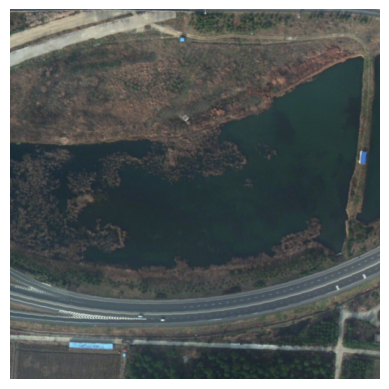

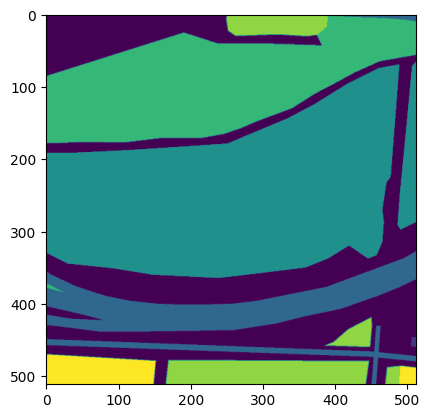

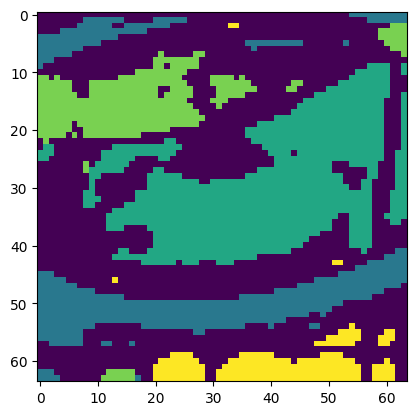

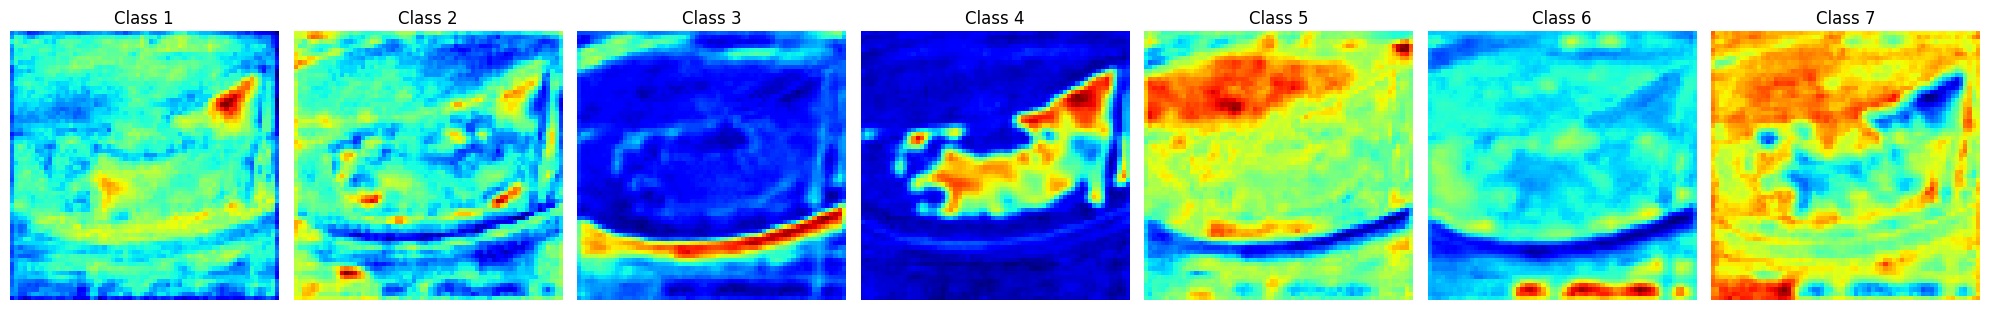

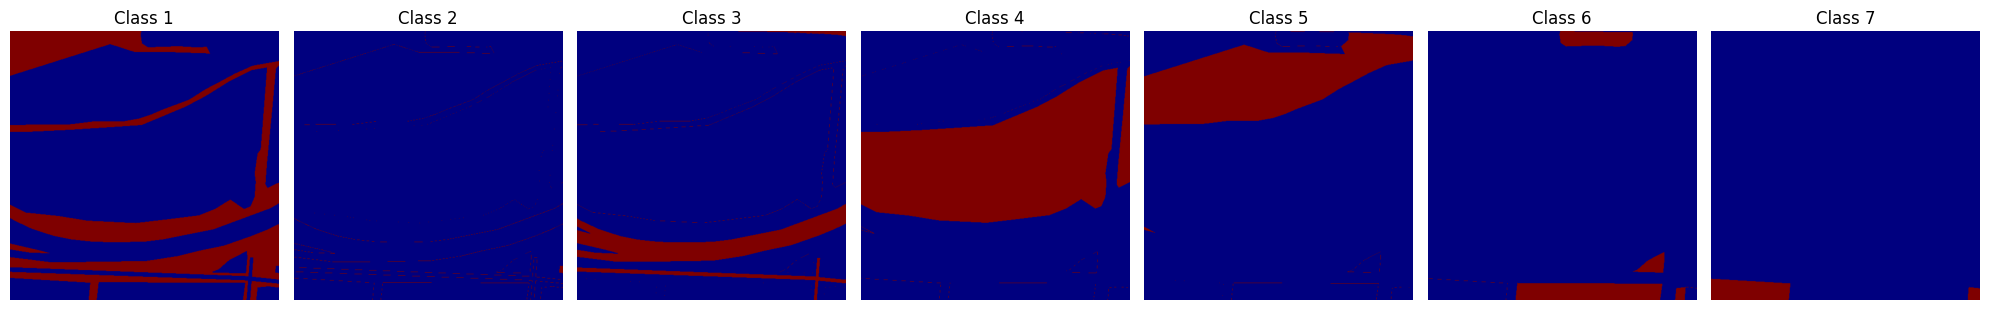

In [18]:
TRAINING=1
if TRAINING:  # Ensure you have a condition for training mode
    # Pick a random batch from the train loader
    a, b = target_dataset[100]
    inputs, targets = a, b  # Assuming the loader returns (input, target) pairs

    # Move the inputs and targets to the same device as the model
    inputs, targets = inputs.to(device), targets.to(device)

    inputs = inputs.unsqueeze(0)  # Add a batch dimension

    # Get the model output for the input
    model.eval()  # Make sure the model is in evaluation mode
    with torch.no_grad():
        output = model(inputs)  # Get model prediction for the input

    output = output[1]

    # Print the random input, output, and ground truth
    # print("\nRandom Sample (Epoch {})".format(i))
    print("Input Tensor: ", inputs.shape)
    print("Ground Truth: ", targets.shape)
    print("Model Output: ", len(output))

    show_image(a)

    plt.imshow(b.argmax(dim=0)) #grouth truth mask
    plt.show()

    output = output.squeeze(0)

    plt.imshow(output.cpu().argmax(dim=0).numpy()) #

    fig, axes = plt.subplots(1, 7, figsize=(20, 5))

    # Itera attraverso i canali della maschera (7 classi)
    for i in range(7):
        # Estrai il canale i-esimo
        mask_class = output[i].cpu().numpy()  # Converti in array numpy per la visualizzazione

        # Visualizza la maschera della classe i
        axes[i].imshow(mask_class, cmap='jet')  # Usa una mappa di colori (ad esempio, 'jet')
        axes[i].set_title(f'Class {i + 1}')
        axes[i].axis('off')  # Disabilita gli assi

    # Mostra il risultato
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 7, figsize=(20, 5))

    # Itera attraverso i canali della maschera (7 classi)
    for i in range(7):
        # Estrai il canale i-esimo
        mask_class = targets[i].cpu().numpy()  # Converti in array numpy per la visualizzazione

        # Visualizza la maschera della classe i
        axes[i].imshow(mask_class, cmap='jet')  # Usa una mappa di colori (ad esempio, 'jet')
        axes[i].set_title(f'Class {i + 1}')
        axes[i].axis('off')  # Disabilita gli assi

    # Mostra il risultato
    plt.tight_layout()
    plt.show()

    model.train()

In [19]:
# --- Calcolo della Loss ---
criterion = torch.nn.CrossEntropyLoss()  # Definisci la funzione di perdita
# La loss richiede che il target sia di tipo (B, H, W), quindi rimuovi il one-hot encoding
targets_class = targets.argmax(dim=0).unsqueeze(0)  # Ground truth in formato (B, H, W)

# --- Upsample l'output del modello ---
# Porta l'output del modello alla stessa risoluzione del target (512 x 512)
output_resized = F.interpolate(output.unsqueeze(0), size=targets_class.shape[1:], mode='bilinear', align_corners=False)

loss = criterion(output_resized, targets_class)  # Calcola la loss

print(f"Loss per l'immagine corrente: {loss.item()}")

# --- Calcolo della mIoU ---
def compute_miou(pred_mask, true_mask, num_classes):
    iou_list = []
    for cls in range(num_classes):
        pred_cls = (pred_mask == cls)  # Predizione per la classe cls
        true_cls = (true_mask == cls)  # Ground truth per la classe cls

        intersection = (pred_cls & true_cls).sum().item()
        union = (pred_cls | true_cls).sum().item()

        if union == 0:
            iou = float('nan')  # Evita la divisione per zero
        else:
            iou = intersection / union

        iou_list.append(iou)

    miou = torch.tensor(iou_list).nanmean().item()  # Calcola la media ignorando NaN
    return miou

# Calcola la mIoU
predicted_mask_resized = output_resized.squeeze(0).argmax(dim=0).cpu()  # Maschera predetta upscalata
true_mask = targets_class.squeeze(0).cpu()  # Ground truth
num_classes = 7  # Numero di classi

miou = compute_miou(predicted_mask_resized, true_mask, num_classes)
print(f"Mean IoU per l'immagine corrente: {miou}")


Loss per l'immagine corrente: 11.029870986938477
Mean IoU per l'immagine corrente: 0.35569095611572266


In [12]:
# unsqueeze function in PyTorch is used to add an extra dimension to a tensor.
# channels: 3 color channels (RGB)

DACS method:
1. ClassMix strategy:
Half of the classes from a source domain image are selected, and the corresponding pixels are cut out and pasted onto an image from the target domain.
The same mixing procedure is applied to the labels (pseudo-labels for the target domain and ground-truth labels for the source domain).
2. Pseudo-labels:
The target domain image is passed through the model before mixing to produce pseudo-labels. These labels are then mixed similarly to how the images are mixed.
3. Cross-domain Mixing:
By combining the two domains at the pixel level, this method attempts to make it harder for the model to learn to discern between the domains. This can mitigate the issue of class distribution differences between source and target domains.

Key Steps for Implementation:
1. Image Mixing:
Select a portion of the source domain image and mix it with the target domain image.
2. Label Mixing:
Use the ground-truth label from the source domain and pseudo-labels from the target domain and mix them similarly to the images.
3. Model Training:
Once the mixed images and labels are prepared, the model can be trained using the usual supervised learning approach, where predictions are made and loss is computed using cross-entropy.

1. Training Phase:

Input: Source images and source labels.

Output: Predicted masks and loss between predictions and source labels.

Augment with target data (via classmix).

Backpropagation and optimization.

2. Validation Phase:

Input: Target images (no labels for target during training).

Output: Predicted masks for the target images.

Compute metrics such as mIoU between predicted masks and true target domain masks.